### USING LOGISTIC REGRESSION TO PREDICT IF ANNOUNCEMENT IS MARKET SENSITIVE

In [203]:

import time
import pandas as pd
import urllib.request
from tika import parser # pip install tika
import requests
from bs4 import BeautifulSoup
import re
import seaborn as sb
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
import nltk

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stopwords_eng = set(stopwords.words("english"))
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers

from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.preprocessing.text import Tokenizer

%matplotlib inline
import gc


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
#from nltk.stem import WordNetLemmatizernltk.download('punkt')

#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer#for word embedding
import gensim
from gensim.models import Word2Vec

import scikitplot as skplt
import matplotlib.pyplot as plt


import seaborn as sb

import multiprocessing
cores = multiprocessing.cpu_count()

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import matplotlib.pyplot as plt

In [204]:
seed = 397

In [205]:
#ff: fast forward to this point
merged_pdf_df = pd.read_csv (r'merged_pdf_df_clean.csv')

In [209]:
merged_pdf_df.reset_index(drop=True, inplace=True)
len(merged_pdf_df)

9015

In [206]:
#turn float to int
merged_pdf_df['market_sens'] = merged_pdf_df['market_sens'].apply(np.int64)

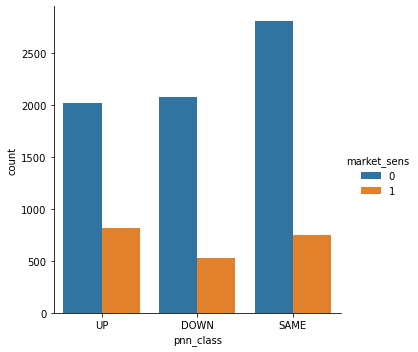

In [214]:
#sb.countplot(data=merged_pdf_df, x='market_sens', order=merged_pdf_df.market_sens.value_counts().index)
#sb.countplot(data=merged_pdf_df, x='pnn_class', order=merged_pdf_df.pnn_class.value_counts().index)
sb.catplot(data=merged_pdf_df,kind='count',x='pnn_class',hue='market_sens')

In [160]:
train, test = train_test_split(merged_pdf_df, test_size=0.3, random_state=42)

import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [161]:
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['clean_text_tok']), tags=[r.market_sens]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['clean_text_tok']), tags=[r.market_sens]), axis=1)
all_tagged = merged_pdf_df.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['clean_text_tok']), tags=[r.market_sens]), axis=1)

In [152]:
test_tagged

6365    ([initial, notice, director, interest, appendi...
2484    ([august, blackmores, limited, jubilee, avenue...
2508    ([berkeley, energia, limited, salamanca, carre...
6100    ([change, director, interest, appendix, change...
1188    ([investor, presentation, sandstone, gold, pro...
                              ...                        
1079    ([buyback, buyback, buyback, summary, name, en...
2226    ([change, director, interest, june, change, di...
3122    ([calidus, resource, calidus, resource, listed...
8225    ([microsoft, word, image, resource, standstill...
5513    ([dividend, distribution, dividend, distributi...
Length: 2705, dtype: object

### 1st iteration
### using non-standardised, training vocab

In [162]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

2022-08-21 09:20:27,359 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dbow,d300,n5,mc2,t8>', 'datetime': '2022-08-21T09:20:27.359978', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}
100%|██████████| 6310/6310 [00:00<00:00, 3203735.41it/s]
2022-08-21 09:20:27,363 : INFO : collecting all words and their counts
2022-08-21 09:20:27,364 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-08-21 09:20:27,728 : INFO : collected 43484 word types and 2 unique tags from a corpus of 6310 examples and 3005735 words
2022-08-21 09:20:27,729 : INFO : Creating a fresh vocabulary
2022-08-21 09:20:27,804 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=2 retains 25760 unique words (59.24% of original 43484, drops 17724)', 'datetime': '2022-08-21T09:20:27.804006', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1

In [163]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 6310/6310 [00:00<00:00, 6310457.38it/s]
2022-08-21 09:20:28,151 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 25760 vocabulary and 300 features, using sg=1 hs=0 sample=0 negative=5 window=5 shrink_windows=True', 'datetime': '2022-08-21T09:20:28.151980', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 09:20:29,160 : INFO : EPOCH 0 - PROGRESS: at 44.52% examples, 1339125 words/s, in_qsize 16, out_qsize 0
2022-08-21 09:20:30,171 : INFO : EPOCH 0 - PROGRESS: at 88.46% examples, 1318049 words/s, in_qsize 15, out_qsize 0
2022-08-21 09:20:30,413 : INFO : EPOCH 0: training on 3005735 raw words (2994321 effective words) took 2.3s, 1327871 effective words/s
2022-08-21 09:20:30,414 : INFO : Doc2Vec lifecycle event {'msg': 'training on 3005735 raw words (2994321 effective words) took 2.3s, 1323320 effective words/s', 'datetime': '2022-

100%|██████████| 6310/6310 [00:00<00:00, 6307449.53it/s]
2022-08-21 09:20:47,221 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 25760 vocabulary and 300 features, using sg=1 hs=0 sample=0 negative=5 window=5 shrink_windows=True', 'datetime': '2022-08-21T09:20:47.221489', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 09:20:48,232 : INFO : EPOCH 0 - PROGRESS: at 34.41% examples, 1043631 words/s, in_qsize 16, out_qsize 0
2022-08-21 09:20:49,233 : INFO : EPOCH 0 - PROGRESS: at 69.57% examples, 1038040 words/s, in_qsize 16, out_qsize 0
2022-08-21 09:20:50,064 : INFO : EPOCH 0: training on 3005735 raw words (2994321 effective words) took 2.8s, 1054646 effective words/s
2022-08-21 09:20:50,065 : INFO : Doc2Vec lifecycle event {'msg': 'training on 3005735 raw words (2994321 effective words) took 2.8s, 1053137 effective words/s', 'datetime': '2022-

100%|██████████| 6310/6310 [00:00<00:00, 6307449.53it/s]
2022-08-21 09:21:20,171 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 25760 vocabulary and 300 features, using sg=1 hs=0 sample=0 negative=5 window=5 shrink_windows=True', 'datetime': '2022-08-21T09:21:20.171522', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 09:21:21,182 : INFO : EPOCH 0 - PROGRESS: at 56.96% examples, 1709953 words/s, in_qsize 15, out_qsize 1
2022-08-21 09:21:21,901 : INFO : EPOCH 0: training on 3005735 raw words (2994321 effective words) took 1.7s, 1734942 effective words/s
2022-08-21 09:21:21,901 : INFO : Doc2Vec lifecycle event {'msg': 'training on 3005735 raw words (2994321 effective words) took 1.7s, 1730968 effective words/s', 'datetime': '2022-08-21T09:21:21.901522', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD6

CPU times: total: 8min 3s
Wall time: 1min 6s


In [164]:
steps = 100
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=steps)) for doc in sents])
    return targets, regressors
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=steps)) for doc in sents])
    return targets, regressors

In [165]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

#ConvergenceWarning: lbfgs failed to converge (status=1):
#STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

#need to scale the data

Testing accuracy 0.7874306839186691
Testing F1 score: 0.7482824589293788


E:\Anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing accuracy 0.7874306839186691
Testing F1 score: 0.7482824589293788


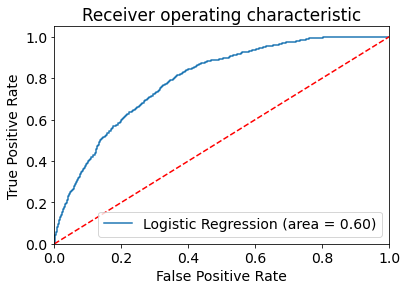

AUC = 0.7927463073508736


Predicted     0    1   All
True                      
0          1982   89  2071
1           486  148   634
All        2468  237  2705

In [166]:

#output ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

auc = metrics.auc(fpr, tpr)
print("AUC =", auc)

pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


In [99]:
X_train

(array([ 0.4785982 , -0.31419343,  0.2285394 , -0.88707954, -0.2372619 ,
         0.46327946,  0.8913427 , -0.225171  ,  0.4834091 ,  0.10262135,
        -0.14074826,  0.18201602, -0.571712  , -0.6522427 , -0.23866683,
         0.66318786, -0.596008  , -0.50952846,  0.14495218, -0.41240597,
         0.6757274 , -0.742717  ,  0.46833763, -1.1029581 , -0.53078467,
        -0.42581487,  1.0028144 ,  1.2895545 , -0.40733665,  1.0172904 ,
        -0.06102902, -0.28161705,  0.02895791, -0.4533608 ,  0.22084972,
        -0.01098303,  0.6033467 ,  0.64331263,  0.06189696,  0.1653344 ,
         0.15906347, -0.1761052 ,  0.22628523, -0.16033234, -0.00201196,
         0.3818807 ,  0.18499416, -0.03798967, -0.04189485, -0.2712067 ,
         0.6658432 , -0.47633976,  0.48488152,  0.06212723,  0.18439466,
        -0.28514943,  0.399011  , -0.37485194,  0.57144994, -0.39246035,
        -0.2826021 , -0.8918329 , -0.07695916,  0.26766828, -0.6312749 ,
        -0.1430759 , -0.12379822,  0.2847034 ,  0.5

### 2nd iteration 
### using standardised variables

In [167]:
from sklearn import preprocessing
import numpy as np


Testing accuracy 0.7656192236598891
Testing F1 score: 0.7239864151794475
Testing accuracy 0.7656192236598891
Testing F1 score: 0.7239864151794475


E:\Anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


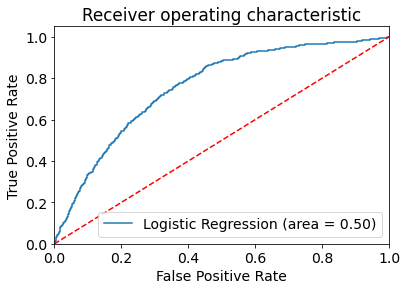

AUC = 0.7576225386781862


Predicted     0    1   All
True                      
0          1948  123  2071
1           511  123   634
All        2459  246  2705

In [168]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

#-- scale x_train / x_test
x_train_scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaler = preprocessing.StandardScaler().fit(X_test)
X_test_scaled = scaler.transform(X_test)
#-- end of scaling


logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

#ConvergenceWarning: lbfgs failed to converge (status=1):
#STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

#need to scale the data

#gensim recommends using the whole dataset to build vocab
#results prior to doing that are
#Testing accuracy 0.8195933456561922
#Testing F1 score: 0.8060417357369553

#results after doing that are 
#Testing accuracy 
#Testing F1 score:




#output ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

auc = metrics.auc(fpr, tpr)
print("AUC =", auc)

pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)



Testing accuracy 0.7656192236598891
Testing F1 score: 0.7239864151794475


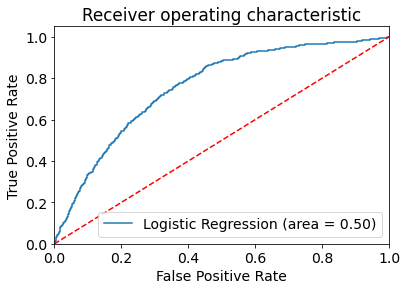

AUC = 0.7576225386781862


Predicted     0    1   All
True                      
0          1948  123  2071
1           511  123   634
All        2459  246  2705

In [169]:

#output ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

auc = metrics.auc(fpr, tpr)
print("AUC =", auc)

pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


### 3rd iteration
### using all_tagged

In [178]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(all_tagged.values)])

2022-08-21 10:20:35,983 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d500,n10,w15,mc5,s0.001,t8>', 'datetime': '2022-08-21T10:20:35.983793', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}
100%|██████████| 9015/9015 [00:00<00:00, 4511591.76it/s]
2022-08-21 10:20:36,005 : INFO : collecting all words and their counts
2022-08-21 10:20:36,006 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-08-21 10:20:36,496 : INFO : collected 52037 word types and 2 unique tags from a corpus of 9015 examples and 4251309 words
2022-08-21 10:20:36,497 : INFO : Creating a fresh vocabulary
2022-08-21 10:20:36,553 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=5 retains 17615 unique words (33.85% of original 52037, drops 34422)', 'datetime': '2022-08-21T10:20:36.553783', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:

In [179]:
%%time
for epoch in range(50):
    model_dmm.train(utils.shuffle([x for x in tqdm(all_tagged.values)]), total_examples=len(all_tagged.values), epochs=3)
    #model_dmm.alpha -= 0.002
    #model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 9015/9015 [00:00<00:00, 3006412.54it/s]
2022-08-21 10:21:31,451 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 17615 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10 window=15 shrink_windows=True', 'datetime': '2022-08-21T10:21:31.451760', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 10:21:32,472 : INFO : EPOCH 0 - PROGRESS: at 24.13% examples, 865091 words/s, in_qsize 16, out_qsize 0
2022-08-21 10:21:33,472 : INFO : EPOCH 0 - PROGRESS: at 48.08% examples, 869912 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:21:34,476 : INFO : EPOCH 0 - PROGRESS: at 73.46% examples, 891843 words/s, in_qsize 16, out_qsize 0
2022-08-21 10:21:35,495 : INFO : EPOCH 0 - PROGRESS: at 95.71% examples, 881330 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:21:35,654 : INFO : EPOCH 0: training on 4251309 raw words (3718136 e

2022-08-21 10:22:14,297 : INFO : EPOCH 0 - PROGRESS: at 21.70% examples, 796681 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:22:15,303 : INFO : EPOCH 0 - PROGRESS: at 44.09% examples, 811246 words/s, in_qsize 16, out_qsize 0
2022-08-21 10:22:16,305 : INFO : EPOCH 0 - PROGRESS: at 67.82% examples, 840523 words/s, in_qsize 16, out_qsize 0
2022-08-21 10:22:17,332 : INFO : EPOCH 0 - PROGRESS: at 92.62% examples, 849950 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:22:17,592 : INFO : EPOCH 0: training on 4251309 raw words (3718071 effective words) took 4.3s, 862162 effective words/s
2022-08-21 10:22:18,595 : INFO : EPOCH 1 - PROGRESS: at 23.49% examples, 876693 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:22:19,602 : INFO : EPOCH 1 - PROGRESS: at 45.06% examples, 835486 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:22:20,603 : INFO : EPOCH 1 - PROGRESS: at 67.82% examples, 845539 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:22:21,604 : INFO : EPOCH 1 - PROGRESS: at 89.96% examp

2022-08-21 10:22:57,698 : INFO : EPOCH 1 - PROGRESS: at 76.46% examples, 934094 words/s, in_qsize 16, out_qsize 0
2022-08-21 10:22:58,594 : INFO : EPOCH 1: training on 4251309 raw words (3718259 effective words) took 3.9s, 950224 effective words/s
2022-08-21 10:22:59,600 : INFO : EPOCH 2 - PROGRESS: at 24.88% examples, 938541 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:23:00,604 : INFO : EPOCH 2 - PROGRESS: at 51.10% examples, 945926 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:23:01,605 : INFO : EPOCH 2 - PROGRESS: at 76.79% examples, 942721 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:23:02,489 : INFO : EPOCH 2: training on 4251309 raw words (3718517 effective words) took 3.9s, 955559 effective words/s
2022-08-21 10:23:02,490 : INFO : Doc2Vec lifecycle event {'msg': 'training on 12753927 raw words (11155869 effective words) took 11.7s, 949842 effective words/s', 'datetime': '2022-08-21T10:23:02.490832', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC

2022-08-21 10:23:37,685 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 17615 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10 window=15 shrink_windows=True', 'datetime': '2022-08-21T10:23:37.685832', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 10:23:38,708 : INFO : EPOCH 0 - PROGRESS: at 26.02% examples, 924912 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:23:39,709 : INFO : EPOCH 0 - PROGRESS: at 51.63% examples, 941942 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:23:40,714 : INFO : EPOCH 0 - PROGRESS: at 77.26% examples, 950400 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:23:41,581 : INFO : EPOCH 0: training on 4251309 raw words (3718653 effective words) took 3.9s, 955531 effective words/s
2022-08-21 10:23:42,599 : INFO : EPOCH 1 - PROGRESS: at 26.02% examples, 929022 words/s, in_qsize 15, out_qsize 0
2022-

2022-08-21 10:24:20,551 : INFO : EPOCH 1: training on 4251309 raw words (3718050 effective words) took 3.9s, 964201 effective words/s
2022-08-21 10:24:21,564 : INFO : EPOCH 2 - PROGRESS: at 25.77% examples, 920991 words/s, in_qsize 16, out_qsize 0
2022-08-21 10:24:22,570 : INFO : EPOCH 2 - PROGRESS: at 51.90% examples, 950161 words/s, in_qsize 16, out_qsize 0
2022-08-21 10:24:23,573 : INFO : EPOCH 2 - PROGRESS: at 76.83% examples, 951806 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:24:24,417 : INFO : EPOCH 2: training on 4251309 raw words (3717740 effective words) took 3.9s, 962474 effective words/s
2022-08-21 10:24:24,417 : INFO : Doc2Vec lifecycle event {'msg': 'training on 12753927 raw words (11153960 effective words) took 11.6s, 960552 effective words/s', 'datetime': '2022-08-21T10:24:24.417832', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [0

2022-08-21 10:25:00,465 : INFO : EPOCH 0 - PROGRESS: at 24.19% examples, 919609 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:25:01,466 : INFO : EPOCH 0 - PROGRESS: at 50.15% examples, 933647 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:25:02,476 : INFO : EPOCH 0 - PROGRESS: at 76.35% examples, 945263 words/s, in_qsize 16, out_qsize 0
2022-08-21 10:25:03,373 : INFO : EPOCH 0: training on 4251309 raw words (3718227 effective words) took 3.9s, 951280 effective words/s
2022-08-21 10:25:04,382 : INFO : EPOCH 1 - PROGRESS: at 24.41% examples, 923685 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:25:05,391 : INFO : EPOCH 1 - PROGRESS: at 50.67% examples, 935717 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:25:06,392 : INFO : EPOCH 1 - PROGRESS: at 76.14% examples, 941225 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:25:07,272 : INFO : EPOCH 1: training on 4251309 raw words (3718079 effective words) took 3.9s, 954345 effective words/s
2022-08-21 10:25:08,278 : INFO : EPOCH 2 - PROGR

2022-08-21 10:25:43,120 : INFO : EPOCH 1: training on 4251309 raw words (3717384 effective words) took 4.0s, 918129 effective words/s
2022-08-21 10:25:44,127 : INFO : EPOCH 2 - PROGRESS: at 25.56% examples, 941438 words/s, in_qsize 16, out_qsize 0
2022-08-21 10:25:45,127 : INFO : EPOCH 2 - PROGRESS: at 50.92% examples, 941721 words/s, in_qsize 16, out_qsize 0
2022-08-21 10:25:46,134 : INFO : EPOCH 2 - PROGRESS: at 77.35% examples, 951591 words/s, in_qsize 16, out_qsize 0
2022-08-21 10:25:47,000 : INFO : EPOCH 2: training on 4251309 raw words (3717788 effective words) took 3.9s, 959051 effective words/s
2022-08-21 10:25:47,000 : INFO : Doc2Vec lifecycle event {'msg': 'training on 12753927 raw words (11153444 effective words) took 12.2s, 914839 effective words/s', 'datetime': '2022-08-21T10:25:47.000832', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [0

2022-08-21 10:26:23,148 : INFO : EPOCH 0 - PROGRESS: at 24.24% examples, 896076 words/s, in_qsize 15, out_qsize 1
2022-08-21 10:26:24,148 : INFO : EPOCH 0 - PROGRESS: at 49.24% examples, 919835 words/s, in_qsize 16, out_qsize 0
2022-08-21 10:26:25,161 : INFO : EPOCH 0 - PROGRESS: at 74.62% examples, 923913 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:26:26,106 : INFO : EPOCH 0: training on 4251309 raw words (3718051 effective words) took 4.0s, 939171 effective words/s
2022-08-21 10:26:27,139 : INFO : EPOCH 1 - PROGRESS: at 25.73% examples, 920219 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:26:28,150 : INFO : EPOCH 1 - PROGRESS: at 52.11% examples, 954999 words/s, in_qsize 16, out_qsize 0
2022-08-21 10:26:29,159 : INFO : EPOCH 1 - PROGRESS: at 77.48% examples, 950882 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:26:30,096 : INFO : EPOCH 1: training on 4251309 raw words (3718414 effective words) took 4.0s, 932776 effective words/s
2022-08-21 10:26:31,128 : INFO : EPOCH 2 - PROGR

2022-08-21 10:27:08,033 : INFO : EPOCH 2 - PROGRESS: at 76.36% examples, 940075 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:27:08,924 : INFO : EPOCH 2: training on 4251309 raw words (3718395 effective words) took 3.9s, 953423 effective words/s
2022-08-21 10:27:08,925 : INFO : Doc2Vec lifecycle event {'msg': 'training on 12753927 raw words (11155394 effective words) took 11.6s, 959510 effective words/s', 'datetime': '2022-08-21T10:27:08.925873', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4506752.15it/s]
2022-08-21 10:27:08,930 : WARNING : Effective 'alpha' higher than previous training cycles
2022-08-21 10:27:08,930 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 17615 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10 window=15 shrink_windows=True', 'datetime': '2022-08-21T10:27:08.930

2022-08-21 10:27:43,236 : INFO : EPOCH 0 - PROGRESS: at 63.99% examples, 1180921 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:27:44,241 : INFO : EPOCH 0 - PROGRESS: at 94.69% examples, 1169557 words/s, in_qsize 14, out_qsize 1
2022-08-21 10:27:44,388 : INFO : EPOCH 0: training on 4251309 raw words (3717123 effective words) took 3.2s, 1176871 effective words/s
2022-08-21 10:27:45,392 : INFO : EPOCH 1 - PROGRESS: at 28.04% examples, 1062868 words/s, in_qsize 16, out_qsize 0
2022-08-21 10:27:46,408 : INFO : EPOCH 1 - PROGRESS: at 62.38% examples, 1145973 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:27:47,415 : INFO : EPOCH 1 - PROGRESS: at 95.53% examples, 1173355 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:27:47,537 : INFO : EPOCH 1: training on 4251309 raw words (3718397 effective words) took 3.1s, 1182439 effective words/s
2022-08-21 10:27:48,541 : INFO : EPOCH 2 - PROGRESS: at 30.87% examples, 1172185 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:27:49,545 : INFO : EPOCH 2

2022-08-21 10:28:21,105 : INFO : EPOCH 2: training on 4251309 raw words (3719024 effective words) took 3.5s, 1051800 effective words/s
2022-08-21 10:28:21,105 : INFO : Doc2Vec lifecycle event {'msg': 'training on 12753927 raw words (11155389 effective words) took 10.5s, 1065913 effective words/s', 'datetime': '2022-08-21T10:28:21.105874', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 3004978.98it/s]
2022-08-21 10:28:21,111 : WARNING : Effective 'alpha' higher than previous training cycles
2022-08-21 10:28:21,111 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 17615 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10 window=15 shrink_windows=True', 'datetime': '2022-08-21T10:28:21.111874', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform

2022-08-21 10:28:55,268 : INFO : EPOCH 0 - PROGRESS: at 60.92% examples, 1093270 words/s, in_qsize 16, out_qsize 0
2022-08-21 10:28:56,294 : INFO : EPOCH 0 - PROGRESS: at 88.13% examples, 1073266 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:28:56,673 : INFO : EPOCH 0: training on 4251309 raw words (3717728 effective words) took 3.4s, 1088157 effective words/s
2022-08-21 10:28:57,682 : INFO : EPOCH 1 - PROGRESS: at 27.81% examples, 1001533 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:28:58,694 : INFO : EPOCH 1 - PROGRESS: at 55.78% examples, 994284 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:28:59,708 : INFO : EPOCH 1 - PROGRESS: at 83.86% examples, 1024066 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:29:00,258 : INFO : EPOCH 1: training on 4251309 raw words (3717872 effective words) took 3.6s, 1038057 effective words/s
2022-08-21 10:29:01,274 : INFO : EPOCH 2 - PROGRESS: at 28.14% examples, 1011307 words/s, in_qsize 14, out_qsize 1
2022-08-21 10:29:02,282 : INFO : EPOCH 2 

2022-08-21 10:29:34,717 : INFO : EPOCH 2: training on 4251309 raw words (3718342 effective words) took 3.3s, 1112233 effective words/s
2022-08-21 10:29:34,718 : INFO : Doc2Vec lifecycle event {'msg': 'training on 12753927 raw words (11154821 effective words) took 10.4s, 1076596 effective words/s', 'datetime': '2022-08-21T10:29:34.718924', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4509977.40it/s]
2022-08-21 10:29:34,723 : WARNING : Effective 'alpha' higher than previous training cycles
2022-08-21 10:29:34,724 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 17615 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10 window=15 shrink_windows=True', 'datetime': '2022-08-21T10:29:34.724924', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform

2022-08-21 10:30:08,239 : INFO : EPOCH 0 - PROGRESS: at 56.65% examples, 1054839 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:30:09,240 : INFO : EPOCH 0 - PROGRESS: at 84.55% examples, 1046375 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:30:09,743 : INFO : EPOCH 0: training on 4251309 raw words (3717853 effective words) took 3.5s, 1059902 effective words/s
2022-08-21 10:30:10,762 : INFO : EPOCH 1 - PROGRESS: at 27.74% examples, 1007737 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:30:11,771 : INFO : EPOCH 1 - PROGRESS: at 56.07% examples, 1035665 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:30:12,779 : INFO : EPOCH 1 - PROGRESS: at 85.15% examples, 1044636 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:30:13,265 : INFO : EPOCH 1: training on 4251309 raw words (3718031 effective words) took 3.5s, 1056761 effective words/s
2022-08-21 10:30:14,270 : INFO : EPOCH 2 - PROGRESS: at 28.19% examples, 1038508 words/s, in_qsize 15, out_qsize 0
2022-08-21 10:30:15,279 : INFO : EPOCH 2

2022-08-21 10:30:48,955 : INFO : EPOCH 2: training on 4251309 raw words (3718014 effective words) took 3.9s, 951043 effective words/s
2022-08-21 10:30:48,956 : INFO : Doc2Vec lifecycle event {'msg': 'training on 12753927 raw words (11155536 effective words) took 11.2s, 994009 effective words/s', 'datetime': '2022-08-21T10:30:48.956962', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4506752.15it/s]
2022-08-21 10:30:48,961 : WARNING : Effective 'alpha' higher than previous training cycles
2022-08-21 10:30:48,962 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 17615 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10 window=15 shrink_windows=True', 'datetime': '2022-08-21T10:30:48.962963', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform':

CPU times: total: 1h 7min 33s
Wall time: 9min 28s


In [180]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.832532347504621
Testing F1 score: 0.8237575440414021


E:\Anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing accuracy 0.832532347504621
Testing F1 score: 0.8237575440414021


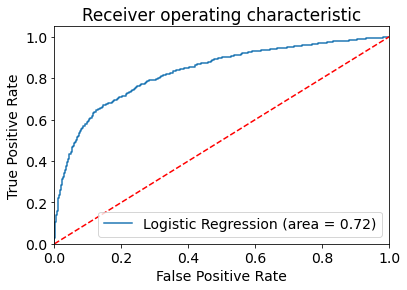

AUC = 0.8314983694004785


Predicted     0    1   All
True                      
0          1923  148  2071
1           305  329   634
All        2228  477  2705

In [181]:
#output ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

auc = metrics.auc(fpr, tpr)
print("AUC =", auc)

pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)



#AUC = 0.9388666076675496
# Testing accuracy 0.8983364140480592
# Testing F1 score: 0.89624406053518

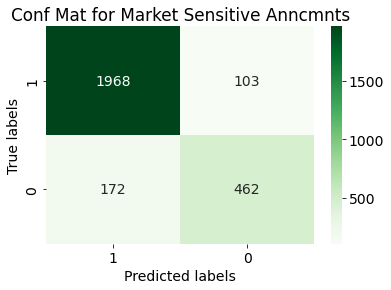

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Greens');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Conf Mat for Market Sensitive Anncmnts'); 
ax.xaxis.set_ticklabels([1, 0]); ax.yaxis.set_ticklabels([1, 0]);

In [201]:
def legit_logit(dm,dm_mean,vec_size,wind,neg,mincnt,wrkrs,alph,minalph,epochrange,epchcnt):

    model_dmm = Doc2Vec(dm=dm, dm_mean=dm_mean, vector_size=vec_size, window=wind, negative=neg, min_count=1
                        ,workers=wrkrs, alpha=alph, min_alpha=minalph)#,dbow_words=1) #comment out this last parameter - only being used for the last iteration
    model_dmm.build_vocab([x for x in tqdm(all_tagged.values)])

    for epoch in range(epochrange):
        model_dmm.train(utils.shuffle([x for x in tqdm(all_tagged.values)]), total_examples=len(all_tagged.values), epochs=epchcnt)
        #model_dmm.alpha -= 0.002
        #model_dmm.min_alpha = model_dmm.alpha

    y_train, X_train = vec_for_learning(model_dmm, train_tagged)
    y_test, X_test = vec_for_learning(model_dmm, test_tagged)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))  

    #visualisations-------------
    logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

    auc = metrics.auc(fpr, tpr)
    rec = metrics.Recall()
    print("AUC =", auc)

    pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


    #heatmap---------------------
    ax= plt.subplot()
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Greens');  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Conf Mat for Market Sensitive Anncmnts'); 
    ax.xaxis.set_ticklabels([1, 0]); ax.yaxis.set_ticklabels([1, 0]);

2022-08-21 11:02:14,401 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d400,n5,w10,s0.001,t8>', 'datetime': '2022-08-21T11:02:14.401143', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}


CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 9015/9015 [00:00<00:00, 4541940.01it/s]
2022-08-21 11:02:14,407 : INFO : collecting all words and their counts
2022-08-21 11:02:14,407 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-08-21 11:02:14,886 : INFO : collected 52037 word types and 2 unique tags from a corpus of 9015 examples and 4251309 words
2022-08-21 11:02:14,886 : INFO : Creating a fresh vocabulary
2022-08-21 11:02:15,024 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 52037 unique words (100.00% of original 52037, drops 0)', 'datetime': '2022-08-21T11:02:15.024119', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'prepare_vocab'}
2022-08-21 11:02:15,025 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 4251309 word corpus (100.00% of original 4251309, drops 0)', 'datetime': '2022-08-21T11:02:15.025120', 'gensim': '4.2.0

2022-08-21 11:02:36,157 : INFO : EPOCH 0 - PROGRESS: at 43.45% examples, 1640368 words/s, in_qsize 14, out_qsize 1
2022-08-21 11:02:37,160 : INFO : EPOCH 0 - PROGRESS: at 88.01% examples, 1662609 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:02:37,423 : INFO : EPOCH 0: training on 4251309 raw words (3780418 effective words) took 2.3s, 1667636 effective words/s
2022-08-21 11:02:38,435 : INFO : EPOCH 1 - PROGRESS: at 44.96% examples, 1685137 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:02:39,437 : INFO : EPOCH 1 - PROGRESS: at 89.66% examples, 1685875 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:02:39,650 : INFO : EPOCH 1: training on 4251309 raw words (3779614 effective words) took 2.2s, 1699495 effective words/s
2022-08-21 11:02:39,651 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7560032 effective words) took 4.5s, 1680363 effective words/s', 'datetime': '2022-08-21T11:02:39.651120', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) 

2022-08-21 11:03:01,696 : INFO : EPOCH 1 - PROGRESS: at 92.56% examples, 1729842 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:03:01,837 : INFO : EPOCH 1: training on 4251309 raw words (3780059 effective words) took 2.2s, 1747952 effective words/s
2022-08-21 11:03:01,838 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7561022 effective words) took 4.4s, 1735054 effective words/s', 'datetime': '2022-08-21T11:03:01.838120', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4506752.15it/s]
2022-08-21 11:03:01,843 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 400 features, using sg=0 hs=0 sample=0.001 negative=5 window=10 shrink_windows=True', 'datetime': '2022-08-21T11:03:01.843119', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit 

100%|██████████| 9015/9015 [00:00<00:00, 4509439.54it/s]
2022-08-21 11:03:24,378 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 400 features, using sg=0 hs=0 sample=0.001 negative=5 window=10 shrink_windows=True', 'datetime': '2022-08-21T11:03:24.378120', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 11:03:25,386 : INFO : EPOCH 0 - PROGRESS: at 42.37% examples, 1607409 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:03:26,387 : INFO : EPOCH 0 - PROGRESS: at 86.69% examples, 1635636 words/s, in_qsize 14, out_qsize 1
2022-08-21 11:03:26,675 : INFO : EPOCH 0: training on 4251309 raw words (3779378 effective words) took 2.3s, 1648021 effective words/s
2022-08-21 11:03:27,686 : INFO : EPOCH 1 - PROGRESS: at 40.84% examples, 1541798 words/s, in_qsize 16, out_qsize 0
2022-08-21 11:03:28,691 : INFO : EPOCH 1 - PROGRESS: at 83.

2022-08-21 11:03:48,833 : INFO : EPOCH 0 - PROGRESS: at 41.85% examples, 1571263 words/s, in_qsize 16, out_qsize 0
2022-08-21 11:03:49,837 : INFO : EPOCH 0 - PROGRESS: at 81.18% examples, 1521724 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:03:50,260 : INFO : EPOCH 0: training on 4251309 raw words (3780554 effective words) took 2.4s, 1557153 effective words/s
2022-08-21 11:03:51,273 : INFO : EPOCH 1 - PROGRESS: at 44.27% examples, 1649352 words/s, in_qsize 14, out_qsize 1
2022-08-21 11:03:52,277 : INFO : EPOCH 1 - PROGRESS: at 88.47% examples, 1654559 words/s, in_qsize 16, out_qsize 0
2022-08-21 11:03:52,534 : INFO : EPOCH 1: training on 4251309 raw words (3780578 effective words) took 2.3s, 1665323 effective words/s
2022-08-21 11:03:52,534 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7561132 effective words) took 4.7s, 1606915 effective words/s', 'datetime': '2022-08-21T11:03:52.534119', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) 

2022-08-21 11:04:17,137 : INFO : EPOCH 1 - PROGRESS: at 83.44% examples, 1572054 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:04:17,494 : INFO : EPOCH 1: training on 4251309 raw words (3780267 effective words) took 2.4s, 1596185 effective words/s
2022-08-21 11:04:17,494 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7561121 effective words) took 4.7s, 1611760 effective words/s', 'datetime': '2022-08-21T11:04:17.494120', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4506752.15it/s]
2022-08-21 11:04:17,499 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 400 features, using sg=0 hs=0 sample=0.001 negative=5 window=10 shrink_windows=True', 'datetime': '2022-08-21T11:04:17.499120', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit 

100%|██████████| 9015/9015 [00:00<00:00, 4507289.37it/s]
2022-08-21 11:04:41,062 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 400 features, using sg=0 hs=0 sample=0.001 negative=5 window=10 shrink_windows=True', 'datetime': '2022-08-21T11:04:41.062119', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 11:04:42,067 : INFO : EPOCH 0 - PROGRESS: at 43.35% examples, 1624261 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:04:43,067 : INFO : EPOCH 0 - PROGRESS: at 87.64% examples, 1657049 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:04:43,335 : INFO : EPOCH 0: training on 4251309 raw words (3780385 effective words) took 2.3s, 1665440 effective words/s
2022-08-21 11:04:44,339 : INFO : EPOCH 1 - PROGRESS: at 43.56% examples, 1635205 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:04:45,344 : INFO : EPOCH 1 - PROGRESS: at 88.

2022-08-21 11:05:05,063 : INFO : EPOCH 0 - PROGRESS: at 42.42% examples, 1594547 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:05:06,065 : INFO : EPOCH 0 - PROGRESS: at 86.71% examples, 1630097 words/s, in_qsize 16, out_qsize 0
2022-08-21 11:05:06,355 : INFO : EPOCH 0: training on 4251309 raw words (3779384 effective words) took 2.3s, 1647890 effective words/s
2022-08-21 11:05:07,366 : INFO : EPOCH 1 - PROGRESS: at 43.53% examples, 1626933 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:05:08,372 : INFO : EPOCH 1 - PROGRESS: at 87.62% examples, 1639612 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:05:08,645 : INFO : EPOCH 1: training on 4251309 raw words (3781069 effective words) took 2.3s, 1653916 effective words/s
2022-08-21 11:05:08,645 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7560453 effective words) took 4.6s, 1648339 effective words/s', 'datetime': '2022-08-21T11:05:08.645119', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) 

2022-08-21 11:05:31,311 : INFO : EPOCH 1 - PROGRESS: at 87.50% examples, 1633945 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:05:31,586 : INFO : EPOCH 1: training on 4251309 raw words (3779778 effective words) took 2.3s, 1647380 effective words/s
2022-08-21 11:05:31,587 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7560280 effective words) took 4.6s, 1642620 effective words/s', 'datetime': '2022-08-21T11:05:31.587119', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 3005695.59it/s]
2022-08-21 11:05:31,593 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 400 features, using sg=0 hs=0 sample=0.001 negative=5 window=10 shrink_windows=True', 'datetime': '2022-08-21T11:05:31.592120', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit 

100%|██████████| 9015/9015 [00:00<00:00, 4506752.15it/s]
2022-08-21 11:05:54,507 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 400 features, using sg=0 hs=0 sample=0.001 negative=5 window=10 shrink_windows=True', 'datetime': '2022-08-21T11:05:54.507120', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 11:05:55,510 : INFO : EPOCH 0 - PROGRESS: at 42.62% examples, 1606719 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:05:56,526 : INFO : EPOCH 0 - PROGRESS: at 87.71% examples, 1638909 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:05:56,784 : INFO : EPOCH 0: training on 4251309 raw words (3779831 effective words) took 2.3s, 1662689 effective words/s
2022-08-21 11:05:57,787 : INFO : EPOCH 1 - PROGRESS: at 43.34% examples, 1641216 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:05:58,801 : INFO : EPOCH 1 - PROGRESS: at 87.

Testing accuracy 0.823290203327172
Testing F1 score: 0.8090326973870778
Testing accuracy 0.823290203327172
Testing F1 score: 0.8090326973870778


E:\Anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


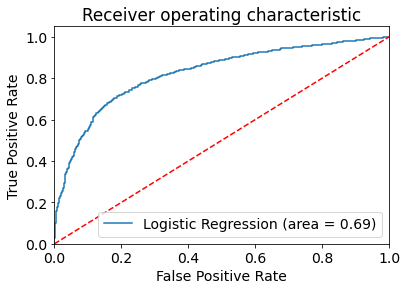

AUC = 0.8245746046881449


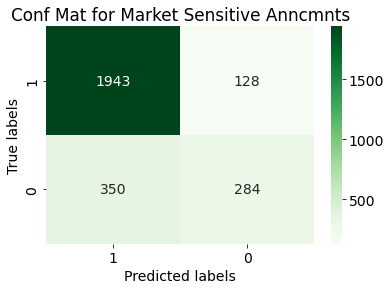

In [188]:
%time
legit_logit(dm=1,dm_mean=1,vec_size=400,wind=10,neg=5,mincnt=3,wrkrs=8,alph=0.065,minalph=0.065,epochrange=50,epchcnt=2)

2022-08-21 11:16:35,377 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d500,n5,w10,s0.001,t8>', 'datetime': '2022-08-21T11:16:35.377581', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}


CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 9015/9015 [00:00<00:00, 4507826.72it/s]
2022-08-21 11:16:35,382 : INFO : collecting all words and their counts
2022-08-21 11:16:35,382 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-08-21 11:16:35,873 : INFO : collected 52037 word types and 2 unique tags from a corpus of 9015 examples and 4251309 words
2022-08-21 11:16:35,874 : INFO : Creating a fresh vocabulary
2022-08-21 11:16:36,008 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 52037 unique words (100.00% of original 52037, drops 0)', 'datetime': '2022-08-21T11:16:36.008884', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'prepare_vocab'}
2022-08-21 11:16:36,009 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 4251309 word corpus (100.00% of original 4251309, drops 0)', 'datetime': '2022-08-21T11:16:36.009883', 'gensim': '4.2.0

2022-08-21 11:16:58,886 : INFO : EPOCH 0 - PROGRESS: at 37.04% examples, 1396609 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:16:59,890 : INFO : EPOCH 0 - PROGRESS: at 79.96% examples, 1501110 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:17:00,386 : INFO : EPOCH 0: training on 4251309 raw words (3780485 effective words) took 2.5s, 1504296 effective words/s
2022-08-21 11:17:01,390 : INFO : EPOCH 1 - PROGRESS: at 36.63% examples, 1396185 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:17:02,393 : INFO : EPOCH 1 - PROGRESS: at 78.20% examples, 1477613 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:17:02,874 : INFO : EPOCH 1: training on 4251309 raw words (3780210 effective words) took 2.5s, 1521184 effective words/s
2022-08-21 11:17:02,874 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7560695 effective words) took 5.0s, 1510557 effective words/s', 'datetime': '2022-08-21T11:17:02.874885', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) 

2022-08-21 11:17:28,286 : INFO : EPOCH 1 - PROGRESS: at 62.26% examples, 1150718 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:17:29,289 : INFO : EPOCH 1 - PROGRESS: at 97.98% examples, 1225841 words/s, in_qsize 9, out_qsize 0
2022-08-21 11:17:29,328 : INFO : EPOCH 1: training on 4251309 raw words (3779339 effective words) took 3.1s, 1233749 effective words/s
2022-08-21 11:17:29,329 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7559437 effective words) took 5.9s, 1276538 effective words/s', 'datetime': '2022-08-21T11:17:29.329911', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4507289.37it/s]
2022-08-21 11:17:29,335 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=10 shrink_windows=True', 'datetime': '2

100%|██████████| 9015/9015 [00:00<00:00, 4507289.37it/s]
2022-08-21 11:17:53,247 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=10 shrink_windows=True', 'datetime': '2022-08-21T11:17:53.247913', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 11:17:54,252 : INFO : EPOCH 0 - PROGRESS: at 41.70% examples, 1567033 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:17:55,263 : INFO : EPOCH 0 - PROGRESS: at 84.02% examples, 1582943 words/s, in_qsize 15, out_qsize 1
2022-08-21 11:17:55,622 : INFO : EPOCH 0: training on 4251309 raw words (3779656 effective words) took 2.4s, 1594036 effective words/s
2022-08-21 11:17:56,635 : INFO : EPOCH 1 - PROGRESS: at 40.74% examples, 1519976 words/s, in_qsize 16, out_qsize 1
2022-08-21 11:17:57,635 : INFO : EPOCH 1 - PROGRESS: at 82.

2022-08-21 11:18:18,527 : INFO : EPOCH 0 - PROGRESS: at 39.93% examples, 1491327 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:18:19,531 : INFO : EPOCH 0 - PROGRESS: at 80.33% examples, 1498009 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:18:20,025 : INFO : EPOCH 0: training on 4251309 raw words (3779415 effective words) took 2.5s, 1508802 effective words/s
2022-08-21 11:18:21,033 : INFO : EPOCH 1 - PROGRESS: at 39.96% examples, 1494975 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:18:22,034 : INFO : EPOCH 1 - PROGRESS: at 80.42% examples, 1503385 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:18:22,528 : INFO : EPOCH 1: training on 4251309 raw words (3780627 effective words) took 2.5s, 1512933 effective words/s
2022-08-21 11:18:22,528 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7560042 effective words) took 5.0s, 1508809 effective words/s', 'datetime': '2022-08-21T11:18:22.528911', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) 

2022-08-21 11:18:47,424 : INFO : EPOCH 1 - PROGRESS: at 79.79% examples, 1498738 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:18:47,920 : INFO : EPOCH 1: training on 4251309 raw words (3781205 effective words) took 2.5s, 1509764 effective words/s
2022-08-21 11:18:47,920 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7561079 effective words) took 5.0s, 1510222 effective words/s', 'datetime': '2022-08-21T11:18:47.920911', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4507289.37it/s]
2022-08-21 11:18:47,925 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=10 shrink_windows=True', 'datetime': '2022-08-21T11:18:47.925911', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit 

100%|██████████| 9015/9015 [00:00<00:00, 4508364.20it/s]
2022-08-21 11:19:14,043 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=10 shrink_windows=True', 'datetime': '2022-08-21T11:19:14.043912', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 11:19:15,047 : INFO : EPOCH 0 - PROGRESS: at 37.86% examples, 1404089 words/s, in_qsize 16, out_qsize 0
2022-08-21 11:19:16,054 : INFO : EPOCH 0 - PROGRESS: at 74.89% examples, 1416641 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:19:16,674 : INFO : EPOCH 0: training on 4251309 raw words (3781265 effective words) took 2.6s, 1438994 effective words/s
2022-08-21 11:19:17,678 : INFO : EPOCH 1 - PROGRESS: at 38.28% examples, 1420095 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:19:18,679 : INFO : EPOCH 1 - PROGRESS: at 75.

2022-08-21 11:19:41,358 : INFO : EPOCH 0 - PROGRESS: at 38.21% examples, 1413225 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:19:42,363 : INFO : EPOCH 0 - PROGRESS: at 76.96% examples, 1438041 words/s, in_qsize 16, out_qsize 0
2022-08-21 11:19:42,940 : INFO : EPOCH 0: training on 4251309 raw words (3779981 effective words) took 2.6s, 1450679 effective words/s
2022-08-21 11:19:43,945 : INFO : EPOCH 1 - PROGRESS: at 36.33% examples, 1375019 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:19:44,951 : INFO : EPOCH 1 - PROGRESS: at 73.21% examples, 1376529 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:19:45,631 : INFO : EPOCH 1: training on 4251309 raw words (3779676 effective words) took 2.7s, 1405862 effective words/s
2022-08-21 11:19:45,632 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7559657 effective words) took 5.3s, 1426068 effective words/s', 'datetime': '2022-08-21T11:19:45.632912', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) 

2022-08-21 11:20:11,177 : INFO : EPOCH 1 - PROGRESS: at 75.98% examples, 1437180 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:20:11,780 : INFO : EPOCH 1: training on 4251309 raw words (3779312 effective words) took 2.6s, 1450393 effective words/s
2022-08-21 11:20:11,781 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7559907 effective words) took 5.2s, 1444210 effective words/s', 'datetime': '2022-08-21T11:20:11.781912', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4508901.81it/s]
2022-08-21 11:20:11,786 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=10 shrink_windows=True', 'datetime': '2022-08-21T11:20:11.786912', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit 

100%|██████████| 9015/9015 [00:00<00:00, 4506215.06it/s]
2022-08-21 11:20:38,151 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=10 shrink_windows=True', 'datetime': '2022-08-21T11:20:38.151914', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 11:20:39,155 : INFO : EPOCH 0 - PROGRESS: at 38.29% examples, 1429112 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:20:40,156 : INFO : EPOCH 0 - PROGRESS: at 76.13% examples, 1441239 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:20:40,752 : INFO : EPOCH 0: training on 4251309 raw words (3780320 effective words) took 2.6s, 1455286 effective words/s
2022-08-21 11:20:41,756 : INFO : EPOCH 1 - PROGRESS: at 38.04% examples, 1421008 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:20:42,761 : INFO : EPOCH 1 - PROGRESS: at 76.

Testing accuracy 0.82181146025878
Testing F1 score: 0.8089115357932076
Testing accuracy 0.82181146025878
Testing F1 score: 0.8089115357932076


E:\Anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


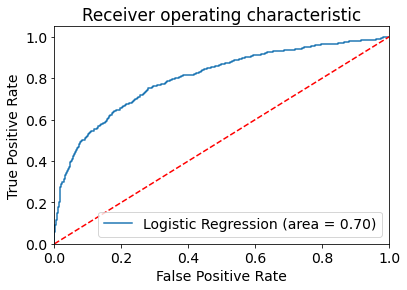

AUC = 0.8023166546586709


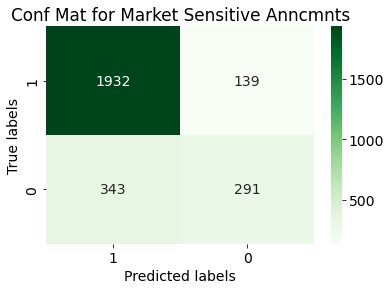

In [189]:
%time
legit_logit(dm=1,dm_mean=1,vec_size=500,wind=10,neg=5,mincnt=3,wrkrs=8,alph=0.065,minalph=0.065,epochrange=50,epchcnt=2)

2022-08-21 11:32:49,606 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d500,n7,w15,s0.001,t8>', 'datetime': '2022-08-21T11:32:49.606166', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}


CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 9015/9015 [00:00<00:00, 4441636.39it/s]
2022-08-21 11:32:49,612 : INFO : collecting all words and their counts
2022-08-21 11:32:49,612 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-08-21 11:32:50,090 : INFO : collected 52037 word types and 2 unique tags from a corpus of 9015 examples and 4251309 words
2022-08-21 11:32:50,091 : INFO : Creating a fresh vocabulary
2022-08-21 11:32:50,228 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 52037 unique words (100.00% of original 52037, drops 0)', 'datetime': '2022-08-21T11:32:50.228163', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'prepare_vocab'}
2022-08-21 11:32:50,228 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 4251309 word corpus (100.00% of original 4251309, drops 0)', 'datetime': '2022-08-21T11:32:50.228163', 'gensim': '4.2.0

2022-08-21 11:33:09,925 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3781095 effective words) took 3.4s, 1109568 effective words/s', 'datetime': '2022-08-21T11:33:09.925136', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4509439.54it/s]
2022-08-21 11:33:09,930 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=7 window=15 shrink_windows=True', 'datetime': '2022-08-21T11:33:09.930136', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 11:33:10,937 : INFO : EPOCH 0 - PROGRESS: at 27.89% examples, 1046893 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:33:11,944 : INFO : EPOCH 0 - PROGRESS: at 56.53% ex

2022-08-21 11:33:52,439 : INFO : EPOCH 0 - PROGRESS: at 30.88% examples, 1116179 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:33:53,445 : INFO : EPOCH 0 - PROGRESS: at 62.05% examples, 1153365 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:33:54,448 : INFO : EPOCH 0 - PROGRESS: at 93.20% examples, 1163511 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:33:54,660 : INFO : EPOCH 0: training on 4251309 raw words (3780145 effective words) took 3.2s, 1166639 effective words/s
2022-08-21 11:33:54,660 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780145 effective words) took 3.2s, 1165276 effective words/s', 'datetime': '2022-08-21T11:33:54.660135', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 3005695.59it/s]
2022-08-21 11:33:54,665 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037

100%|██████████| 9015/9015 [00:00<00:00, 4504604.55it/s]
2022-08-21 11:34:13,764 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=7 window=15 shrink_windows=True', 'datetime': '2022-08-21T11:34:13.764136', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 11:34:14,773 : INFO : EPOCH 0 - PROGRESS: at 30.07% examples, 1112024 words/s, in_qsize 16, out_qsize 0
2022-08-21 11:34:15,777 : INFO : EPOCH 0 - PROGRESS: at 60.59% examples, 1138010 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:34:16,785 : INFO : EPOCH 0 - PROGRESS: at 91.97% examples, 1154697 words/s, in_qsize 16, out_qsize 0
2022-08-21 11:34:17,027 : INFO : EPOCH 0: training on 4251309 raw words (3780486 effective words) took 3.3s, 1159911 effective words/s
2022-08-21 11:34:17,027 : INFO : Doc2Vec lifecycle event {'

2022-08-21 11:34:34,705 : INFO : EPOCH 0 - PROGRESS: at 27.15% examples, 1046172 words/s, in_qsize 14, out_qsize 1
2022-08-21 11:34:35,715 : INFO : EPOCH 0 - PROGRESS: at 57.90% examples, 1106549 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:34:36,719 : INFO : EPOCH 0 - PROGRESS: at 88.74% examples, 1110588 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:34:37,062 : INFO : EPOCH 0: training on 4251309 raw words (3779070 effective words) took 3.4s, 1125691 effective words/s
2022-08-21 11:34:37,063 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3779070 effective words) took 3.4s, 1124202 effective words/s', 'datetime': '2022-08-21T11:34:37.063135', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4505141.26it/s]
2022-08-21 11:34:37,068 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037

2022-08-21 11:34:57,504 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780057 effective words) took 3.5s, 1080205 effective words/s', 'datetime': '2022-08-21T11:34:57.504136', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 3004024.04it/s]
2022-08-21 11:34:57,510 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=7 window=15 shrink_windows=True', 'datetime': '2022-08-21T11:34:57.510136', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 11:34:58,514 : INFO : EPOCH 0 - PROGRESS: at 28.36% examples, 1056864 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:34:59,543 : INFO : EPOCH 0 - PROGRESS: at 57.84% ex

2022-08-21 11:35:39,226 : INFO : EPOCH 0 - PROGRESS: at 23.44% examples, 906093 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:35:40,235 : INFO : EPOCH 0 - PROGRESS: at 50.70% examples, 958406 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:35:41,240 : INFO : EPOCH 0 - PROGRESS: at 79.83% examples, 1000628 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:35:41,892 : INFO : EPOCH 0: training on 4251309 raw words (3780322 effective words) took 3.7s, 1029252 effective words/s
2022-08-21 11:35:41,892 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780322 effective words) took 3.7s, 1028025 effective words/s', 'datetime': '2022-08-21T11:35:41.892136', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}


Testing accuracy 0.833641404805915
Testing F1 score: 0.8230603178151782
Testing accuracy 0.833641404805915
Testing F1 score: 0.8230603178151782


E:\Anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


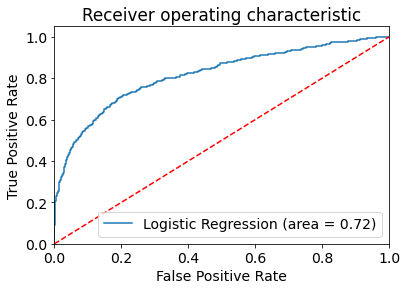

AUC = 0.817004997661868


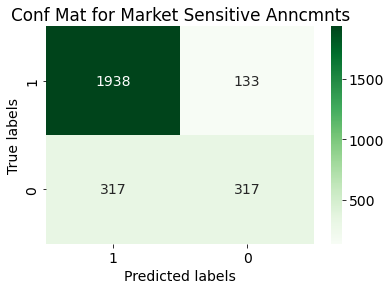

In [190]:
%time
legit_logit(dm=1,dm_mean=1,vec_size=500,wind=15,neg=7,mincnt=5,wrkrs=8,alph=0.065,minalph=0.065,epochrange=50,epchcnt=1)

2022-08-21 11:51:32,742 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d500,n5,w12,s0.001,t8>', 'datetime': '2022-08-21T11:51:32.742747', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}


CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 9015/9015 [00:00<00:00, 3035373.73it/s]
2022-08-21 11:51:32,747 : INFO : collecting all words and their counts
2022-08-21 11:51:32,747 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-08-21 11:51:33,229 : INFO : collected 52037 word types and 2 unique tags from a corpus of 9015 examples and 4251309 words
2022-08-21 11:51:33,230 : INFO : Creating a fresh vocabulary
2022-08-21 11:51:33,368 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 52037 unique words (100.00% of original 52037, drops 0)', 'datetime': '2022-08-21T11:51:33.368745', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'prepare_vocab'}
2022-08-21 11:51:33,369 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 4251309 word corpus (100.00% of original 4251309, drops 0)', 'datetime': '2022-08-21T11:51:33.369745', 'gensim': '4.2.0

100%|██████████| 9015/9015 [00:00<00:00, 4507289.37it/s]
2022-08-21 11:51:57,544 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=12 shrink_windows=True', 'datetime': '2022-08-21T11:51:57.544312', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 11:51:58,552 : INFO : EPOCH 0 - PROGRESS: at 36.18% examples, 1342841 words/s, in_qsize 16, out_qsize 0
2022-08-21 11:51:59,566 : INFO : EPOCH 0 - PROGRESS: at 72.57% examples, 1354634 words/s, in_qsize 16, out_qsize 0
2022-08-21 11:52:00,326 : INFO : EPOCH 0: training on 4251309 raw words (3779476 effective words) took 2.8s, 1360513 effective words/s
2022-08-21 11:52:01,341 : INFO : EPOCH 1 - PROGRESS: at 34.41% examples, 1259172 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:52:02,341 : INFO : EPOCH 1 - PROGRESS: at 69.

2022-08-21 11:52:27,229 : INFO : EPOCH 0 - PROGRESS: at 34.29% examples, 1306249 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:52:28,232 : INFO : EPOCH 0 - PROGRESS: at 69.57% examples, 1324253 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:52:29,075 : INFO : EPOCH 0: training on 4251309 raw words (3780437 effective words) took 2.8s, 1327413 effective words/s
2022-08-21 11:52:30,080 : INFO : EPOCH 1 - PROGRESS: at 32.82% examples, 1247215 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:52:31,087 : INFO : EPOCH 1 - PROGRESS: at 68.18% examples, 1295461 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:52:31,985 : INFO : EPOCH 1: training on 4251309 raw words (3780887 effective words) took 2.9s, 1300776 effective words/s
2022-08-21 11:52:31,986 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7561324 effective words) took 5.8s, 1312378 effective words/s', 'datetime': '2022-08-21T11:52:31.986313', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) 

2022-08-21 11:52:59,031 : INFO : EPOCH 1 - PROGRESS: at 33.72% examples, 1277028 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:53:00,040 : INFO : EPOCH 1 - PROGRESS: at 69.55% examples, 1296382 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:53:00,883 : INFO : EPOCH 1: training on 4251309 raw words (3781157 effective words) took 2.9s, 1323341 effective words/s
2022-08-21 11:53:00,883 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7562069 effective words) took 5.7s, 1322783 effective words/s', 'datetime': '2022-08-21T11:53:00.883312', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 3004978.98it/s]
2022-08-21 11:53:00,889 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=12 shrink_windows=True', 'datetime': '

100%|██████████| 9015/9015 [00:00<00:00, 4506215.06it/s]
2022-08-21 11:53:29,656 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=12 shrink_windows=True', 'datetime': '2022-08-21T11:53:29.656312', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 11:53:30,662 : INFO : EPOCH 0 - PROGRESS: at 33.68% examples, 1300129 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:53:31,663 : INFO : EPOCH 0 - PROGRESS: at 69.94% examples, 1323408 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:53:32,503 : INFO : EPOCH 0: training on 4251309 raw words (3780876 effective words) took 2.8s, 1330030 effective words/s
2022-08-21 11:53:33,506 : INFO : EPOCH 1 - PROGRESS: at 33.18% examples, 1284694 words/s, in_qsize 16, out_qsize 1
2022-08-21 11:53:34,510 : INFO : EPOCH 1 - PROGRESS: at 68.

2022-08-21 11:53:59,528 : INFO : EPOCH 0 - PROGRESS: at 34.17% examples, 1291166 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:54:00,530 : INFO : EPOCH 0 - PROGRESS: at 68.85% examples, 1299722 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:54:01,399 : INFO : EPOCH 0: training on 4251309 raw words (3780432 effective words) took 2.9s, 1310690 effective words/s
2022-08-21 11:54:02,407 : INFO : EPOCH 1 - PROGRESS: at 34.17% examples, 1302106 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:54:03,407 : INFO : EPOCH 1 - PROGRESS: at 69.13% examples, 1310701 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:54:04,294 : INFO : EPOCH 1: training on 4251309 raw words (3780741 effective words) took 2.9s, 1307839 effective words/s
2022-08-21 11:54:04,295 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7561173 effective words) took 5.8s, 1307600 effective words/s', 'datetime': '2022-08-21T11:54:04.294823', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) 

2022-08-21 11:54:31,223 : INFO : EPOCH 0 - PROGRESS: at 88.67% examples, 1119545 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:54:31,513 : INFO : EPOCH 0: training on 4251309 raw words (3779551 effective words) took 3.3s, 1145860 effective words/s
2022-08-21 11:54:32,521 : INFO : EPOCH 1 - PROGRESS: at 32.78% examples, 1232230 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:54:33,528 : INFO : EPOCH 1 - PROGRESS: at 66.52% examples, 1255710 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:54:34,529 : INFO : EPOCH 1 - PROGRESS: at 98.75% examples, 1240896 words/s, in_qsize 5, out_qsize 1
2022-08-21 11:54:34,543 : INFO : EPOCH 1: training on 4251309 raw words (3780810 effective words) took 3.0s, 1249187 effective words/s
2022-08-21 11:54:34,543 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7560361 effective words) took 6.3s, 1193956 effective words/s', 'datetime': '2022-08-21T11:54:34.543334', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [

2022-08-21 11:55:01,735 : INFO : EPOCH 1 - PROGRESS: at 33.83% examples, 1269199 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:55:02,735 : INFO : EPOCH 1 - PROGRESS: at 65.11% examples, 1243119 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:55:03,747 : INFO : EPOCH 1 - PROGRESS: at 97.80% examples, 1224357 words/s, in_qsize 11, out_qsize 0
2022-08-21 11:55:03,787 : INFO : EPOCH 1: training on 4251309 raw words (3780367 effective words) took 3.1s, 1236313 effective words/s
2022-08-21 11:55:03,788 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7561309 effective words) took 5.9s, 1274929 effective words/s', 'datetime': '2022-08-21T11:55:03.788333', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4508364.20it/s]
2022-08-21 11:55:03,793 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037

2022-08-21 11:55:32,577 : INFO : EPOCH 1 - PROGRESS: at 69.46% examples, 1310255 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:55:33,413 : INFO : EPOCH 1: training on 4251309 raw words (3780437 effective words) took 2.8s, 1327077 effective words/s
2022-08-21 11:55:33,414 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7559602 effective words) took 5.7s, 1315641 effective words/s', 'datetime': '2022-08-21T11:55:33.414333', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4505678.09it/s]
2022-08-21 11:55:33,419 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=12 shrink_windows=True', 'datetime': '2022-08-21T11:55:33.419334', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit 

2022-08-21 11:56:02,981 : INFO : EPOCH 1: training on 4251309 raw words (3780842 effective words) took 3.0s, 1244711 effective words/s
2022-08-21 11:56:02,982 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7560969 effective words) took 6.1s, 1245043 effective words/s', 'datetime': '2022-08-21T11:56:02.982333', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4507826.72it/s]
2022-08-21 11:56:02,988 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=12 shrink_windows=True', 'datetime': '2022-08-21T11:56:02.988334', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 11:56:03,996 : INFO : EPOCH 0 - PR

2022-08-21 11:56:33,395 : INFO : EPOCH 1 - PROGRESS: at 95.83% examples, 1204705 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:56:33,492 : INFO : EPOCH 1: training on 4251309 raw words (3779523 effective words) took 3.1s, 1213056 effective words/s
2022-08-21 11:56:33,492 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7560307 effective words) took 6.1s, 1235804 effective words/s', 'datetime': '2022-08-21T11:56:33.492334', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4507289.37it/s]
2022-08-21 11:56:33,498 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=12 shrink_windows=True', 'datetime': '2022-08-21T11:56:33.498335', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit 

2022-08-21 11:57:01,888 : INFO : EPOCH 1 - PROGRESS: at 32.20% examples, 1210749 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:57:02,891 : INFO : EPOCH 1 - PROGRESS: at 64.96% examples, 1228198 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:57:03,900 : INFO : EPOCH 1 - PROGRESS: at 98.17% examples, 1228871 words/s, in_qsize 8, out_qsize 0
2022-08-21 11:57:03,936 : INFO : EPOCH 1: training on 4251309 raw words (3780814 effective words) took 3.1s, 1237002 effective words/s
2022-08-21 11:57:03,936 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7561235 effective words) took 6.1s, 1246190 effective words/s', 'datetime': '2022-08-21T11:57:03.936333', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 3005456.69it/s]
2022-08-21 11:57:03,942 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 

2022-08-21 11:57:32,138 : INFO : EPOCH 1 - PROGRESS: at 32.11% examples, 1225492 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:57:33,139 : INFO : EPOCH 1 - PROGRESS: at 65.69% examples, 1243440 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:57:34,140 : INFO : EPOCH 1 - PROGRESS: at 99.58% examples, 1250592 words/s, in_qsize 2, out_qsize 1
2022-08-21 11:57:34,144 : INFO : EPOCH 1: training on 4251309 raw words (3781223 effective words) took 3.0s, 1254559 effective words/s
2022-08-21 11:57:34,145 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7561769 effective words) took 6.0s, 1258146 effective words/s', 'datetime': '2022-08-21T11:57:34.145333', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 3004024.04it/s]
2022-08-21 11:57:34,151 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 

2022-08-21 11:58:02,259 : INFO : EPOCH 1 - PROGRESS: at 32.38% examples, 1227941 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:58:03,262 : INFO : EPOCH 1 - PROGRESS: at 66.60% examples, 1244627 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:58:04,258 : INFO : EPOCH 1: training on 4251309 raw words (3779929 effective words) took 3.0s, 1258445 effective words/s
2022-08-21 11:58:04,258 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7559412 effective words) took 6.0s, 1259338 effective words/s', 'datetime': '2022-08-21T11:58:04.258333', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4507289.37it/s]
2022-08-21 11:58:04,264 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=12 shrink_windows=True', 'datetime': '

2022-08-21 11:58:31,580 : INFO : EPOCH 0: training on 4251309 raw words (3780607 effective words) took 3.0s, 1262483 effective words/s
2022-08-21 11:58:32,588 : INFO : EPOCH 1 - PROGRESS: at 32.65% examples, 1223271 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:58:33,597 : INFO : EPOCH 1 - PROGRESS: at 65.69% examples, 1232783 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:58:34,598 : INFO : EPOCH 1 - PROGRESS: at 98.41% examples, 1233663 words/s, in_qsize 7, out_qsize 1
2022-08-21 11:58:34,630 : INFO : EPOCH 1: training on 4251309 raw words (3779854 effective words) took 3.0s, 1240753 effective words/s
2022-08-21 11:58:34,631 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7560461 effective words) took 6.0s, 1250040 effective words/s', 'datetime': '2022-08-21T11:58:34.631333', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 

2022-08-21 11:59:01,828 : INFO : EPOCH 0 - PROGRESS: at 31.95% examples, 1186324 words/s, in_qsize 16, out_qsize 0
2022-08-21 11:59:02,829 : INFO : EPOCH 0 - PROGRESS: at 64.73% examples, 1207189 words/s, in_qsize 16, out_qsize 1
2022-08-21 11:59:03,831 : INFO : EPOCH 0 - PROGRESS: at 96.32% examples, 1213046 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:59:03,924 : INFO : EPOCH 0: training on 4251309 raw words (3780722 effective words) took 3.1s, 1219170 effective words/s
2022-08-21 11:59:04,938 : INFO : EPOCH 1 - PROGRESS: at 30.18% examples, 1104125 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:59:05,941 : INFO : EPOCH 1 - PROGRESS: at 61.94% examples, 1151015 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:59:06,951 : INFO : EPOCH 1 - PROGRESS: at 92.97% examples, 1165062 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:59:07,144 : INFO : EPOCH 1: training on 4251309 raw words (3780682 effective words) took 3.2s, 1175271 effective words/s
2022-08-21 11:59:07,145 : INFO : Doc2Vec

100%|██████████| 9015/9015 [00:00<00:00, 3005934.54it/s]
2022-08-21 11:59:32,543 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=12 shrink_windows=True', 'datetime': '2022-08-21T11:59:32.543332', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 11:59:33,548 : INFO : EPOCH 0 - PROGRESS: at 31.60% examples, 1174154 words/s, in_qsize 16, out_qsize 0
2022-08-21 11:59:34,548 : INFO : EPOCH 0 - PROGRESS: at 63.61% examples, 1195054 words/s, in_qsize 15, out_qsize 0
2022-08-21 11:59:35,554 : INFO : EPOCH 0 - PROGRESS: at 95.76% examples, 1202195 words/s, in_qsize 16, out_qsize 0
2022-08-21 11:59:35,661 : INFO : EPOCH 0: training on 4251309 raw words (3780848 effective words) took 3.1s, 1214003 effective words/s
2022-08-21 11:59:36,667 : INFO : EPOCH 1 - PROGRESS: at 31.

2022-08-21 12:00:03,915 : INFO : EPOCH 1: training on 4251309 raw words (3779937 effective words) took 3.1s, 1209857 effective words/s
2022-08-21 12:00:03,915 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7560599 effective words) took 6.2s, 1211846 effective words/s', 'datetime': '2022-08-21T12:00:03.915355', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4507826.72it/s]
2022-08-21 12:00:03,920 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=12 shrink_windows=True', 'datetime': '2022-08-21T12:00:03.920356', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 12:00:04,924 : INFO : EPOCH 0 - PR

2022-08-21 12:00:33,152 : INFO : EPOCH 1 - PROGRESS: at 65.02% examples, 1210081 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:00:34,155 : INFO : EPOCH 1 - PROGRESS: at 97.96% examples, 1227841 words/s, in_qsize 9, out_qsize 0
2022-08-21 12:00:34,188 : INFO : EPOCH 1: training on 4251309 raw words (3780210 effective words) took 3.0s, 1240033 effective words/s
2022-08-21 12:00:34,188 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7560564 effective words) took 6.1s, 1245780 effective words/s', 'datetime': '2022-08-21T12:00:34.188356', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4512130.14it/s]
2022-08-21 12:00:34,194 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=12 shrink_windows=True', 'datetime': '2

2022-08-21 12:01:02,911 : INFO : EPOCH 1 - PROGRESS: at 31.36% examples, 1200442 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:01:03,911 : INFO : EPOCH 1 - PROGRESS: at 63.07% examples, 1196676 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:01:04,920 : INFO : EPOCH 1 - PROGRESS: at 94.36% examples, 1182012 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:01:05,073 : INFO : EPOCH 1: training on 4251309 raw words (3779781 effective words) took 3.2s, 1194016 effective words/s
2022-08-21 12:01:05,073 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7560884 effective words) took 6.6s, 1149178 effective words/s', 'datetime': '2022-08-21T12:01:05.073866', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4506215.06it/s]
2022-08-21 12:01:05,079 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037

2022-08-21 12:01:30,711 : INFO : EPOCH 0 - PROGRESS: at 31.31% examples, 1201871 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:01:31,719 : INFO : EPOCH 0 - PROGRESS: at 64.35% examples, 1212673 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:01:32,737 : INFO : EPOCH 0 - PROGRESS: at 97.69% examples, 1217492 words/s, in_qsize 11, out_qsize 0
2022-08-21 12:01:32,784 : INFO : EPOCH 0: training on 4251309 raw words (3780212 effective words) took 3.1s, 1228308 effective words/s
2022-08-21 12:01:33,795 : INFO : EPOCH 1 - PROGRESS: at 30.83% examples, 1181154 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:01:34,797 : INFO : EPOCH 1 - PROGRESS: at 63.61% examples, 1196886 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:01:35,798 : INFO : EPOCH 1 - PROGRESS: at 95.62% examples, 1199369 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:01:35,919 : INFO : EPOCH 1: training on 4251309 raw words (3779451 effective words) took 3.1s, 1206806 effective words/s
2022-08-21 12:01:35,919 : INFO : Doc2Vec

Testing accuracy 0.8051756007393716
Testing F1 score: 0.7866996262743331
Testing accuracy 0.8051756007393716
Testing F1 score: 0.7866996262743331


E:\Anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


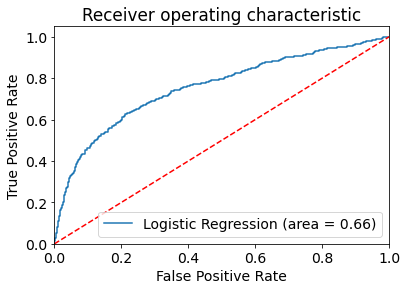

AUC = 0.754624093878664


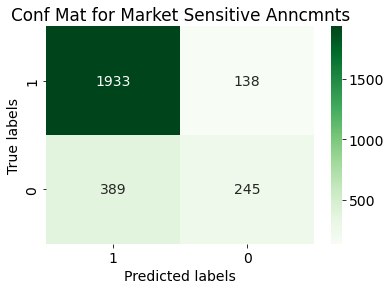

In [191]:
%time
legit_logit(dm=1,dm_mean=1,vec_size=500,wind=12,neg=5,mincnt=5,wrkrs=8,alph=0.065,minalph=0.065,epochrange=100,epchcnt=2)

2022-08-21 12:14:19,864 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dbow,d500,n5,s0.001,t8>', 'datetime': '2022-08-21T12:14:19.864305', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}


CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 9015/9015 [00:00<00:00, 4488029.74it/s]
2022-08-21 12:14:19,870 : INFO : collecting all words and their counts
2022-08-21 12:14:19,870 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-08-21 12:14:20,354 : INFO : collected 52037 word types and 2 unique tags from a corpus of 9015 examples and 4251309 words
2022-08-21 12:14:20,355 : INFO : Creating a fresh vocabulary
2022-08-21 12:14:20,489 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 52037 unique words (100.00% of original 52037, drops 0)', 'datetime': '2022-08-21T12:14:20.488338', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'prepare_vocab'}
2022-08-21 12:14:20,489 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 4251309 word corpus (100.00% of original 4251309, drops 0)', 'datetime': '2022-08-21T12:14:20.489328', 'gensim': '4.2.0

2022-08-21 12:14:43,924 : INFO : EPOCH 0 - PROGRESS: at 58.25% examples, 734773 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:14:44,924 : INFO : EPOCH 0 - PROGRESS: at 78.18% examples, 737620 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:14:45,948 : INFO : EPOCH 0 - PROGRESS: at 98.06% examples, 734646 words/s, in_qsize 10, out_qsize 0
2022-08-21 12:14:46,001 : INFO : EPOCH 0: training on 4251309 raw words (3779671 effective words) took 5.1s, 742239 effective words/s
2022-08-21 12:14:46,002 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3779671 effective words) took 5.1s, 741663 effective words/s', 'datetime': '2022-08-21T12:14:46.002353', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4505141.26it/s]
2022-08-21 12:14:46,007 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 voca

2022-08-21 12:15:15,717 : INFO : EPOCH 0: training on 4251309 raw words (3780936 effective words) took 6.2s, 609921 effective words/s
2022-08-21 12:15:15,718 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780936 effective words) took 6.2s, 609538 effective words/s', 'datetime': '2022-08-21T12:15:15.718369', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4507826.72it/s]
2022-08-21 12:15:15,723 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022-08-21T12:15:15.723369', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 12:15:16,730 : INFO : EPOCH 0 - PROG

2022-08-21 12:15:46,975 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3779854 effective words) took 6.2s, 610848 effective words/s', 'datetime': '2022-08-21T12:15:46.975371', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4504067.96it/s]
2022-08-21 12:15:46,981 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022-08-21T12:15:46.981370', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 12:15:47,991 : INFO : EPOCH 0 - PROGRESS: at 14.94% examples, 552540 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:15:49,011 : INFO : EPOCH 0 - PROGRESS: at 31.59% exam

100%|██████████| 9015/9015 [00:00<00:00, 4511053.51it/s]
2022-08-21 12:16:18,007 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022-08-21T12:16:18.007422', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 12:16:19,012 : INFO : EPOCH 0 - PROGRESS: at 14.46% examples, 566029 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:16:20,034 : INFO : EPOCH 0 - PROGRESS: at 30.96% examples, 588627 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:16:21,034 : INFO : EPOCH 0 - PROGRESS: at 47.86% examples, 602557 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:16:22,053 : INFO : EPOCH 0 - PROGRESS: at 63.32% examples, 594403 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:16:23,088 : INFO : EPOCH 0 - PROGRESS: at 79.80% examples, 596242 wor

2022-08-21 12:16:49,945 : INFO : EPOCH 0 - PROGRESS: at 15.54% examples, 580199 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:16:50,966 : INFO : EPOCH 0 - PROGRESS: at 31.88% examples, 591265 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:16:51,976 : INFO : EPOCH 0 - PROGRESS: at 47.63% examples, 594480 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:16:52,977 : INFO : EPOCH 0 - PROGRESS: at 65.09% examples, 603585 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:16:53,977 : INFO : EPOCH 0 - PROGRESS: at 80.54% examples, 601296 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:16:54,988 : INFO : EPOCH 0 - PROGRESS: at 96.47% examples, 603189 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:16:55,136 : INFO : EPOCH 0: training on 4251309 raw words (3781286 effective words) took 6.2s, 610661 effective words/s
2022-08-21 12:16:55,137 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3781286 effective words) took 6.2s, 610253 effective words/s', 'datetime': '2022-08-2

2022-08-21 12:17:21,995 : INFO : EPOCH 0 - PROGRESS: at 31.14% examples, 605367 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:17:23,004 : INFO : EPOCH 0 - PROGRESS: at 47.44% examples, 608294 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:17:24,014 : INFO : EPOCH 0 - PROGRESS: at 64.09% examples, 605041 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:17:25,022 : INFO : EPOCH 0 - PROGRESS: at 80.17% examples, 605194 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:17:26,029 : INFO : EPOCH 0 - PROGRESS: at 96.34% examples, 603235 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:17:26,182 : INFO : EPOCH 0: training on 4251309 raw words (3780464 effective words) took 6.2s, 609604 effective words/s
2022-08-21 12:17:26,183 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780464 effective words) took 6.2s, 609198 effective words/s', 'datetime': '2022-08-21T12:17:26.183120', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]

2022-08-21 12:17:53,999 : INFO : EPOCH 0 - PROGRESS: at 49.24% examples, 612826 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:17:55,006 : INFO : EPOCH 0 - PROGRESS: at 65.62% examples, 617467 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:17:56,013 : INFO : EPOCH 0 - PROGRESS: at 81.03% examples, 612749 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:17:57,032 : INFO : EPOCH 0 - PROGRESS: at 97.71% examples, 610436 words/s, in_qsize 10, out_qsize 0
2022-08-21 12:17:57,100 : INFO : EPOCH 0: training on 4251309 raw words (3780285 effective words) took 6.1s, 616493 effective words/s
2022-08-21 12:17:57,101 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780285 effective words) took 6.1s, 616052 effective words/s', 'datetime': '2022-08-21T12:17:57.101189', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4508901.81i

2022-08-21 12:18:25,759 : INFO : EPOCH 0 - PROGRESS: at 64.88% examples, 614976 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:18:26,767 : INFO : EPOCH 0 - PROGRESS: at 80.78% examples, 611344 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:18:27,772 : INFO : EPOCH 0 - PROGRESS: at 97.19% examples, 608773 words/s, in_qsize 12, out_qsize 1
2022-08-21 12:18:27,868 : INFO : EPOCH 0: training on 4251309 raw words (3779833 effective words) took 6.1s, 616449 effective words/s
2022-08-21 12:18:27,868 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3779833 effective words) took 6.1s, 616086 effective words/s', 'datetime': '2022-08-21T12:18:27.868749', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4510515.40it/s]
2022-08-21 12:18:27,873 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 voca

2022-08-21 12:18:57,693 : INFO : EPOCH 0 - PROGRESS: at 81.67% examples, 605514 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:18:58,698 : INFO : EPOCH 0 - PROGRESS: at 97.93% examples, 606965 words/s, in_qsize 10, out_qsize 0
2022-08-21 12:18:58,767 : INFO : EPOCH 0: training on 4251309 raw words (3780778 effective words) took 6.2s, 612979 effective words/s
2022-08-21 12:18:58,768 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780778 effective words) took 6.2s, 612593 effective words/s', 'datetime': '2022-08-21T12:18:58.768319', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4507289.37it/s]
2022-08-21 12:18:58,773 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022

Testing accuracy 0.8916820702402958
Testing F1 score: 0.8909806202952419
Testing accuracy 0.8916820702402958
Testing F1 score: 0.8909806202952419


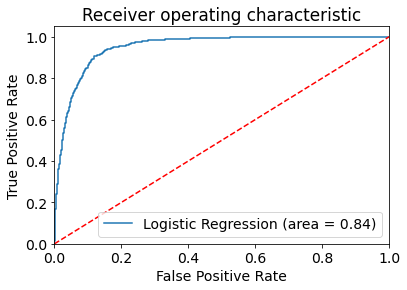

AUC = 0.9498139395314902


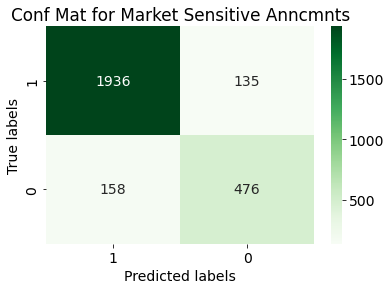

In [192]:
%time
legit_logit(dm=0,dm_mean=1,vec_size=500,wind=20,neg=5,mincnt=3,wrkrs=8,alph=0.065,minalph=0.065,epochrange=50,epchcnt=1)

2022-08-21 12:28:11,563 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d450,n6,w12,s0.001,t8>', 'datetime': '2022-08-21T12:28:11.562172', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}


CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 9015/9015 [00:00<00:00, 4509977.40it/s]
2022-08-21 12:28:11,568 : INFO : collecting all words and their counts
2022-08-21 12:28:11,568 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-08-21 12:28:12,053 : INFO : collected 52037 word types and 2 unique tags from a corpus of 9015 examples and 4251309 words
2022-08-21 12:28:12,054 : INFO : Creating a fresh vocabulary
2022-08-21 12:28:12,185 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 52037 unique words (100.00% of original 52037, drops 0)', 'datetime': '2022-08-21T12:28:12.185170', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'prepare_vocab'}
2022-08-21 12:28:12,186 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 4251309 word corpus (100.00% of original 4251309, drops 0)', 'datetime': '2022-08-21T12:28:12.186171', 'gensim': '4.2.0

100%|██████████| 9015/9015 [00:00<00:00, 4509977.40it/s]
2022-08-21 12:28:35,415 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 450 features, using sg=0 hs=0 sample=0.001 negative=6 window=12 shrink_windows=True', 'datetime': '2022-08-21T12:28:35.415172', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 12:28:36,421 : INFO : EPOCH 0 - PROGRESS: at 37.93% examples, 1428572 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:28:37,429 : INFO : EPOCH 0 - PROGRESS: at 74.01% examples, 1382737 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:28:38,237 : INFO : EPOCH 0: training on 4251309 raw words (3779559 effective words) took 2.8s, 1341116 effective words/s
2022-08-21 12:28:39,242 : INFO : EPOCH 1 - PROGRESS: at 34.56% examples, 1291423 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:28:40,245 : INFO : EPOCH 1 - PROGRESS: at 71.

2022-08-21 12:29:03,970 : INFO : EPOCH 0 - PROGRESS: at 34.39% examples, 1289578 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:29:04,976 : INFO : EPOCH 0 - PROGRESS: at 68.30% examples, 1293084 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:29:05,820 : INFO : EPOCH 0: training on 4251309 raw words (3780535 effective words) took 2.9s, 1322942 effective words/s
2022-08-21 12:29:06,828 : INFO : EPOCH 1 - PROGRESS: at 35.37% examples, 1336504 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:29:07,829 : INFO : EPOCH 1 - PROGRESS: at 71.31% examples, 1352873 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:29:08,629 : INFO : EPOCH 1: training on 4251309 raw words (3779414 effective words) took 2.8s, 1346750 effective words/s
2022-08-21 12:29:08,630 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7559949 effective words) took 5.7s, 1333027 effective words/s', 'datetime': '2022-08-21T12:29:08.630172', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) 

2022-08-21 12:29:36,581 : INFO : EPOCH 1 - PROGRESS: at 70.56% examples, 1341231 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:29:37,375 : INFO : EPOCH 1: training on 4251309 raw words (3780740 effective words) took 2.8s, 1350930 effective words/s
2022-08-21 12:29:37,375 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7561472 effective words) took 5.5s, 1379351 effective words/s', 'datetime': '2022-08-21T12:29:37.375172', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 3004740.19it/s]
2022-08-21 12:29:37,381 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 450 features, using sg=0 hs=0 sample=0.001 negative=6 window=12 shrink_windows=True', 'datetime': '2022-08-21T12:29:37.381172', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit 

100%|██████████| 9015/9015 [00:00<00:00, 4507826.72it/s]
2022-08-21 12:30:04,904 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 450 features, using sg=0 hs=0 sample=0.001 negative=6 window=12 shrink_windows=True', 'datetime': '2022-08-21T12:30:04.904171', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 12:30:05,913 : INFO : EPOCH 0 - PROGRESS: at 34.22% examples, 1294958 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:30:06,919 : INFO : EPOCH 0 - PROGRESS: at 70.06% examples, 1319973 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:30:07,767 : INFO : EPOCH 0: training on 4251309 raw words (3780863 effective words) took 2.9s, 1323251 effective words/s
2022-08-21 12:30:08,782 : INFO : EPOCH 1 - PROGRESS: at 33.98% examples, 1276237 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:30:09,788 : INFO : EPOCH 1 - PROGRESS: at 71.

2022-08-21 12:30:33,679 : INFO : EPOCH 0 - PROGRESS: at 35.07% examples, 1304808 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:30:34,681 : INFO : EPOCH 0 - PROGRESS: at 70.40% examples, 1330468 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:30:35,506 : INFO : EPOCH 0: training on 4251309 raw words (3780302 effective words) took 2.8s, 1335679 effective words/s
2022-08-21 12:30:36,513 : INFO : EPOCH 1 - PROGRESS: at 35.97% examples, 1338693 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:30:37,515 : INFO : EPOCH 1 - PROGRESS: at 70.42% examples, 1330445 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:30:38,428 : INFO : EPOCH 1: training on 4251309 raw words (3780109 effective words) took 2.9s, 1295048 effective words/s
2022-08-21 12:30:38,429 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7560411 effective words) took 5.8s, 1313379 effective words/s', 'datetime': '2022-08-21T12:30:38.429172', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) 

2022-08-21 12:31:05,483 : INFO : EPOCH 1 - PROGRESS: at 70.31% examples, 1332548 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:31:06,284 : INFO : EPOCH 1: training on 4251309 raw words (3779660 effective words) took 2.8s, 1346873 effective words/s
2022-08-21 12:31:06,284 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7559482 effective words) took 5.6s, 1352316 effective words/s', 'datetime': '2022-08-21T12:31:06.284171', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 3005217.82it/s]
2022-08-21 12:31:06,290 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 450 features, using sg=0 hs=0 sample=0.001 negative=6 window=12 shrink_windows=True', 'datetime': '2022-08-21T12:31:06.290172', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit 

100%|██████████| 9015/9015 [00:00<00:00, 3005217.82it/s]
2022-08-21 12:31:34,424 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 450 features, using sg=0 hs=0 sample=0.001 negative=6 window=12 shrink_windows=True', 'datetime': '2022-08-21T12:31:34.423683', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 12:31:35,430 : INFO : EPOCH 0 - PROGRESS: at 33.58% examples, 1270029 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:31:36,437 : INFO : EPOCH 0 - PROGRESS: at 69.51% examples, 1307903 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:31:37,262 : INFO : EPOCH 0: training on 4251309 raw words (3779531 effective words) took 2.8s, 1333258 effective words/s
2022-08-21 12:31:38,266 : INFO : EPOCH 1 - PROGRESS: at 35.61% examples, 1348341 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:31:39,281 : INFO : EPOCH 1 - PROGRESS: at 72.

2022-08-21 12:32:03,890 : INFO : EPOCH 0 - PROGRESS: at 34.28% examples, 1297350 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:32:04,891 : INFO : EPOCH 0 - PROGRESS: at 67.90% examples, 1288392 words/s, in_qsize 14, out_qsize 1
2022-08-21 12:32:05,794 : INFO : EPOCH 0: training on 4251309 raw words (3780041 effective words) took 2.9s, 1298758 effective words/s
2022-08-21 12:32:06,803 : INFO : EPOCH 1 - PROGRESS: at 34.28% examples, 1299047 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:32:07,808 : INFO : EPOCH 1 - PROGRESS: at 67.90% examples, 1286761 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:32:08,709 : INFO : EPOCH 1: training on 4251309 raw words (3780827 effective words) took 2.9s, 1298800 effective words/s
2022-08-21 12:32:08,709 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7560868 effective words) took 5.8s, 1297239 effective words/s', 'datetime': '2022-08-21T12:32:08.709684', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) 

2022-08-21 12:32:36,272 : INFO : EPOCH 1 - PROGRESS: at 34.03% examples, 1262083 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:32:37,273 : INFO : EPOCH 1 - PROGRESS: at 67.09% examples, 1259125 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:32:38,286 : INFO : EPOCH 1 - PROGRESS: at 98.36% examples, 1232806 words/s, in_qsize 7, out_qsize 1
2022-08-21 12:32:38,315 : INFO : EPOCH 1: training on 4251309 raw words (3780162 effective words) took 3.0s, 1240256 effective words/s
2022-08-21 12:32:38,316 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7560246 effective words) took 6.1s, 1246402 effective words/s', 'datetime': '2022-08-21T12:32:38.316685', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4507826.72it/s]
2022-08-21 12:32:38,322 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 

2022-08-21 12:33:07,624 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7560493 effective words) took 5.9s, 1283833 effective words/s', 'datetime': '2022-08-21T12:33:07.624684', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4511053.51it/s]
2022-08-21 12:33:07,630 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 450 features, using sg=0 hs=0 sample=0.001 negative=6 window=12 shrink_windows=True', 'datetime': '2022-08-21T12:33:07.629684', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 12:33:08,645 : INFO : EPOCH 0 - PROGRESS: at 33.22% examples, 1246089 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:33:09,650 : INFO : EPOCH 0 - PROGRESS: at 66.70% ex

2022-08-21 12:33:38,051 : INFO : EPOCH 0 - PROGRESS: at 33.58% examples, 1261951 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:33:39,058 : INFO : EPOCH 0 - PROGRESS: at 67.25% examples, 1267943 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:33:40,005 : INFO : EPOCH 0: training on 4251309 raw words (3780562 effective words) took 3.0s, 1279376 effective words/s
2022-08-21 12:33:41,011 : INFO : EPOCH 1 - PROGRESS: at 33.14% examples, 1243768 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:33:42,013 : INFO : EPOCH 1 - PROGRESS: at 66.62% examples, 1258062 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:33:42,970 : INFO : EPOCH 1: training on 4251309 raw words (3780577 effective words) took 3.0s, 1276370 effective words/s
2022-08-21 12:33:42,971 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7561139 effective words) took 5.9s, 1276264 effective words/s', 'datetime': '2022-08-21T12:33:42.971684', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) 

2022-08-21 12:34:11,635 : INFO : EPOCH 1 - PROGRESS: at 67.33% examples, 1249262 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:34:12,609 : INFO : EPOCH 1: training on 4251309 raw words (3780434 effective words) took 3.0s, 1262722 effective words/s
2022-08-21 12:34:12,609 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7560958 effective words) took 5.9s, 1275056 effective words/s', 'datetime': '2022-08-21T12:34:12.609683', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4506752.15it/s]
2022-08-21 12:34:12,615 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 450 features, using sg=0 hs=0 sample=0.001 negative=6 window=12 shrink_windows=True', 'datetime': '2022-08-21T12:34:12.615684', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit 

100%|██████████| 9015/9015 [00:00<00:00, 4510515.40it/s]
2022-08-21 12:34:42,358 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 450 features, using sg=0 hs=0 sample=0.001 negative=6 window=12 shrink_windows=True', 'datetime': '2022-08-21T12:34:42.358683', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 12:34:43,387 : INFO : EPOCH 0 - PROGRESS: at 33.60% examples, 1231857 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:34:44,405 : INFO : EPOCH 0 - PROGRESS: at 68.59% examples, 1268690 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:34:45,313 : INFO : EPOCH 0: training on 4251309 raw words (3780893 effective words) took 3.0s, 1281368 effective words/s
2022-08-21 12:34:46,321 : INFO : EPOCH 1 - PROGRESS: at 33.36% examples, 1247741 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:34:47,324 : INFO : EPOCH 1 - PROGRESS: at 67.

2022-08-21 12:35:13,292 : INFO : EPOCH 0 - PROGRESS: at 30.50% examples, 1156920 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:35:14,307 : INFO : EPOCH 0 - PROGRESS: at 64.97% examples, 1203188 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:35:15,315 : INFO : EPOCH 0 - PROGRESS: at 97.74% examples, 1220218 words/s, in_qsize 11, out_qsize 0
2022-08-21 12:35:15,371 : INFO : EPOCH 0: training on 4251309 raw words (3780759 effective words) took 3.1s, 1226439 effective words/s
2022-08-21 12:35:16,378 : INFO : EPOCH 1 - PROGRESS: at 33.13% examples, 1251103 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:35:17,383 : INFO : EPOCH 1 - PROGRESS: at 63.15% examples, 1174200 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:35:18,396 : INFO : EPOCH 1 - PROGRESS: at 94.54% examples, 1182128 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:35:18,554 : INFO : EPOCH 1: training on 4251309 raw words (3779779 effective words) took 3.2s, 1188720 effective words/s
2022-08-21 12:35:18,554 : INFO : Doc2Vec

2022-08-21 12:35:43,862 : INFO : EPOCH 0 - PROGRESS: at 30.25% examples, 1142225 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:35:44,868 : INFO : EPOCH 0 - PROGRESS: at 61.64% examples, 1157105 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:35:45,872 : INFO : EPOCH 0 - PROGRESS: at 93.08% examples, 1167916 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:35:46,072 : INFO : EPOCH 0: training on 4251309 raw words (3779614 effective words) took 3.2s, 1176548 effective words/s
2022-08-21 12:35:47,084 : INFO : EPOCH 1 - PROGRESS: at 31.15% examples, 1169556 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:35:48,090 : INFO : EPOCH 1 - PROGRESS: at 64.02% examples, 1196115 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:35:49,091 : INFO : EPOCH 1 - PROGRESS: at 96.43% examples, 1206586 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:35:49,196 : INFO : EPOCH 1: training on 4251309 raw words (3780309 effective words) took 3.1s, 1211582 effective words/s
2022-08-21 12:35:49,196 : INFO : Doc2Vec

100%|██████████| 9015/9015 [00:00<00:00, 4510515.40it/s]
2022-08-21 12:36:13,698 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 450 features, using sg=0 hs=0 sample=0.001 negative=6 window=12 shrink_windows=True', 'datetime': '2022-08-21T12:36:13.698192', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 12:36:14,709 : INFO : EPOCH 0 - PROGRESS: at 31.97% examples, 1208556 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:36:15,709 : INFO : EPOCH 0 - PROGRESS: at 65.47% examples, 1222478 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:36:16,716 : INFO : EPOCH 0 - PROGRESS: at 97.87% examples, 1228627 words/s, in_qsize 10, out_qsize 0
2022-08-21 12:36:16,770 : INFO : EPOCH 0: training on 4251309 raw words (3780410 effective words) took 3.1s, 1232218 effective words/s
2022-08-21 12:36:17,775 : INFO : EPOCH 1 - PROGRESS: at 31.

100%|██████████| 9015/9015 [00:00<00:00, 4504067.96it/s]
2022-08-21 12:36:43,985 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 450 features, using sg=0 hs=0 sample=0.001 negative=6 window=12 shrink_windows=True', 'datetime': '2022-08-21T12:36:43.985192', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 12:36:44,990 : INFO : EPOCH 0 - PROGRESS: at 32.95% examples, 1239753 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:36:45,992 : INFO : EPOCH 0 - PROGRESS: at 66.44% examples, 1249546 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:36:46,964 : INFO : EPOCH 0: training on 4251309 raw words (3778852 effective words) took 3.0s, 1270321 effective words/s
2022-08-21 12:36:47,984 : INFO : EPOCH 1 - PROGRESS: at 32.32% examples, 1195033 words/s, in_qsize 14, out_qsize 1
2022-08-21 12:36:48,984 : INFO : EPOCH 1 - PROGRESS: at 65.

100%|██████████| 9015/9015 [00:00<00:00, 4508901.81it/s]
2022-08-21 12:37:14,247 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 450 features, using sg=0 hs=0 sample=0.001 negative=6 window=12 shrink_windows=True', 'datetime': '2022-08-21T12:37:14.247192', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 12:37:15,252 : INFO : EPOCH 0 - PROGRESS: at 32.04% examples, 1216651 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:37:16,252 : INFO : EPOCH 0 - PROGRESS: at 65.29% examples, 1233653 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:37:17,254 : INFO : EPOCH 0 - PROGRESS: at 99.00% examples, 1244103 words/s, in_qsize 5, out_qsize 1
2022-08-21 12:37:17,277 : INFO : EPOCH 0: training on 4251309 raw words (3779781 effective words) took 3.0s, 1248841 effective words/s
2022-08-21 12:37:18,284 : INFO : EPOCH 1 - PROGRESS: at 33.0

100%|██████████| 9015/9015 [00:00<00:00, 3007847.47it/s]
2022-08-21 12:37:44,623 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 450 features, using sg=0 hs=0 sample=0.001 negative=6 window=12 shrink_windows=True', 'datetime': '2022-08-21T12:37:44.623192', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 12:37:45,628 : INFO : EPOCH 0 - PROGRESS: at 32.29% examples, 1237591 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:37:46,631 : INFO : EPOCH 0 - PROGRESS: at 65.87% examples, 1245522 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:37:47,633 : INFO : EPOCH 0 - PROGRESS: at 99.40% examples, 1249276 words/s, in_qsize 3, out_qsize 1
2022-08-21 12:37:47,641 : INFO : EPOCH 0: training on 4251309 raw words (3779802 effective words) took 3.0s, 1254063 effective words/s
2022-08-21 12:37:48,652 : INFO : EPOCH 1 - PROGRESS: at 32.4

2022-08-21 12:38:15,187 : INFO : EPOCH 1: training on 4251309 raw words (3779575 effective words) took 3.0s, 1262584 effective words/s
2022-08-21 12:38:15,187 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7560240 effective words) took 6.0s, 1251751 effective words/s', 'datetime': '2022-08-21T12:38:15.187193', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4505678.09it/s]
2022-08-21 12:38:15,193 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 450 features, using sg=0 hs=0 sample=0.001 negative=6 window=12 shrink_windows=True', 'datetime': '2022-08-21T12:38:15.193192', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 12:38:16,200 : INFO : EPOCH 0 - PR

2022-08-21 12:38:45,459 : INFO : EPOCH 1: training on 4251309 raw words (3779841 effective words) took 3.0s, 1259856 effective words/s
2022-08-21 12:38:45,459 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7559656 effective words) took 6.1s, 1235806 effective words/s', 'datetime': '2022-08-21T12:38:45.459192', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4508364.20it/s]
2022-08-21 12:38:45,465 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 450 features, using sg=0 hs=0 sample=0.001 negative=6 window=12 shrink_windows=True', 'datetime': '2022-08-21T12:38:45.465193', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 12:38:46,484 : INFO : EPOCH 0 - PR

2022-08-21 12:39:13,856 : INFO : EPOCH 1 - PROGRESS: at 32.46% examples, 1215641 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:39:14,864 : INFO : EPOCH 1 - PROGRESS: at 65.93% examples, 1236935 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:39:15,869 : INFO : EPOCH 1 - PROGRESS: at 99.23% examples, 1245342 words/s, in_qsize 3, out_qsize 1
2022-08-21 12:39:15,874 : INFO : EPOCH 1: training on 4251309 raw words (3780536 effective words) took 3.0s, 1251650 effective words/s
2022-08-21 12:39:15,875 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7561327 effective words) took 6.1s, 1245229 effective words/s', 'datetime': '2022-08-21T12:39:15.875193', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4508901.81it/s]
2022-08-21 12:39:15,880 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 

2022-08-21 12:39:42,205 : INFO : EPOCH 0 - PROGRESS: at 69.67% examples, 1303262 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:39:43,046 : INFO : EPOCH 0: training on 4251309 raw words (3780305 effective words) took 2.9s, 1325332 effective words/s
2022-08-21 12:39:44,053 : INFO : EPOCH 1 - PROGRESS: at 33.54% examples, 1235065 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:39:45,073 : INFO : EPOCH 1 - PROGRESS: at 67.13% examples, 1248914 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:39:45,993 : INFO : EPOCH 1: training on 4251309 raw words (3780054 effective words) took 2.9s, 1284126 effective words/s
2022-08-21 12:39:45,994 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7560359 effective words) took 5.8s, 1302819 effective words/s', 'datetime': '2022-08-21T12:39:45.994192', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015

2022-08-21 12:40:15,249 : INFO : EPOCH 1: training on 4251309 raw words (3781114 effective words) took 2.9s, 1298287 effective words/s
2022-08-21 12:40:15,249 : INFO : Doc2Vec lifecycle event {'msg': 'training on 8502618 raw words (7560307 effective words) took 5.8s, 1303758 effective words/s', 'datetime': '2022-08-21T12:40:15.249702', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 3006173.52it/s]
2022-08-21 12:40:15,255 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 450 features, using sg=0 hs=0 sample=0.001 negative=6 window=12 shrink_windows=True', 'datetime': '2022-08-21T12:40:15.255702', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 12:40:16,263 : INFO : EPOCH 0 - PR

Testing accuracy 0.8059149722735675
Testing F1 score: 0.7857024368149513
Testing accuracy 0.8059149722735675
Testing F1 score: 0.7857024368149513


E:\Anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


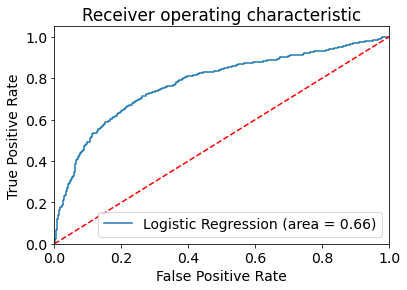

AUC = 0.7772864569608549


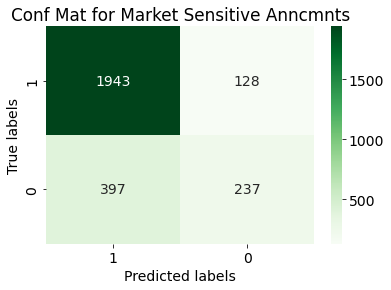

In [193]:
%time
legit_logit(dm=1,dm_mean=1,vec_size=450,wind=12,neg=6,mincnt=4,wrkrs=8,alph=0.065,minalph=0.065,epochrange=128,epchcnt=2)

In [ ]:
### take best performing one and tweak

2022-08-21 12:57:17,908 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dbow,d500,n5,s0.001,t8>', 'datetime': '2022-08-21T12:57:17.908027', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}
100%|██████████| 9015/9015 [00:00<00:00, 4424485.20it/s]
2022-08-21 12:57:17,913 : INFO : collecting all words and their counts
2022-08-21 12:57:17,913 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-08-21 12:57:18,401 : INFO : collected 52037 word types and 2 unique tags from a corpus of 9015 examples and 4251309 words
2022-08-21 12:57:18,402 : INFO : Creating a fresh vocabulary
2022-08-21 12:57:18,541 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 52037 unique words (100.00% of original 52037, drops 0)', 'datetime': '2022-08-21T12:57:18.541026', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1

2022-08-21 12:57:39,416 : INFO : EPOCH 0 - PROGRESS: at 17.30% examples, 612910 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:57:40,425 : INFO : EPOCH 0 - PROGRESS: at 33.97% examples, 623989 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:57:41,425 : INFO : EPOCH 0 - PROGRESS: at 51.03% examples, 635447 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:57:42,429 : INFO : EPOCH 0 - PROGRESS: at 68.24% examples, 637188 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:57:43,449 : INFO : EPOCH 0 - PROGRESS: at 85.16% examples, 636537 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:57:44,264 : INFO : EPOCH 0: training on 4251309 raw words (3779620 effective words) took 5.9s, 642182 effective words/s
2022-08-21 12:57:44,264 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3779620 effective words) took 5.9s, 641755 effective words/s', 'datetime': '2022-08-21T12:57:44.264026', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]

2022-08-21 12:58:12,815 : INFO : EPOCH 0 - PROGRESS: at 63.77% examples, 595403 words/s, in_qsize 16, out_qsize 0
2022-08-21 12:58:13,845 : INFO : EPOCH 0 - PROGRESS: at 80.99% examples, 599387 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:58:14,874 : INFO : EPOCH 0 - PROGRESS: at 97.50% examples, 599008 words/s, in_qsize 11, out_qsize 1
2022-08-21 12:58:14,971 : INFO : EPOCH 0: training on 4251309 raw words (3780365 effective words) took 6.2s, 606148 effective words/s
2022-08-21 12:58:14,972 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780365 effective words) took 6.2s, 605711 effective words/s', 'datetime': '2022-08-21T12:58:14.972594', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4506752.15it/s]
2022-08-21 12:58:14,978 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 voca

2022-08-21 12:58:45,564 : INFO : EPOCH 0 - PROGRESS: at 78.34% examples, 582535 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:58:46,575 : INFO : EPOCH 0 - PROGRESS: at 92.96% examples, 582609 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:58:46,949 : INFO : EPOCH 0: training on 4251309 raw words (3779680 effective words) took 6.4s, 587572 effective words/s
2022-08-21 12:58:46,949 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3779680 effective words) took 6.4s, 587175 effective words/s', 'datetime': '2022-08-21T12:58:46.949650', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4506215.06it/s]
2022-08-21 12:58:46,955 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022

2022-08-21 12:59:18,693 : INFO : EPOCH 0 - PROGRESS: at 93.64% examples, 578392 words/s, in_qsize 15, out_qsize 0
2022-08-21 12:59:19,014 : INFO : EPOCH 0: training on 4251309 raw words (3779644 effective words) took 6.4s, 587550 effective words/s
2022-08-21 12:59:19,015 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3779644 effective words) took 6.4s, 587178 effective words/s', 'datetime': '2022-08-21T12:59:19.015176', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4504604.55it/s]
2022-08-21 12:59:19,021 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022-08-21T12:59:19.021177', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AM

2022-08-21 12:59:51,110 : INFO : EPOCH 0: training on 4251309 raw words (3780076 effective words) took 6.4s, 588525 effective words/s
2022-08-21 12:59:51,111 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780076 effective words) took 6.4s, 588146 effective words/s', 'datetime': '2022-08-21T12:59:51.111335', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4508364.20it/s]
2022-08-21 12:59:51,117 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 500 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022-08-21T12:59:51.117335', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 12:59:52,149 : INFO : EPOCH 0 - PROG

2022-08-21 13:00:23,116 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780590 effective words) took 6.4s, 590649 effective words/s', 'datetime': '2022-08-21T13:00:23.116963', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}


Testing accuracy 0.8902033271719039
Testing F1 score: 0.8898683206838343
Testing accuracy 0.8902033271719039
Testing F1 score: 0.8898683206838343


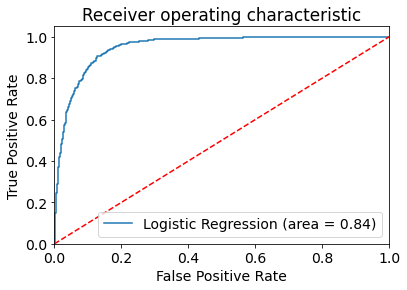

AUC = 0.9500896410853197
CPU times: total: 0 ns
Wall time: 0 ns


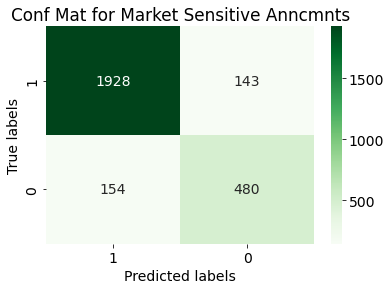

In [194]:

legit_logit(dm=0,dm_mean=1,vec_size=500,wind=20,neg=5,mincnt=3,wrkrs=8,alph=0.065,minalph=0.065,epochrange=30,epchcnt=1)
%time

2022-08-21 13:13:01,324 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dbow,d800,n5,s0.001,t8>', 'datetime': '2022-08-21T13:13:01.324215', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}


CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 9015/9015 [00:00<00:00, 4508901.81it/s]
2022-08-21 13:13:01,330 : INFO : collecting all words and their counts
2022-08-21 13:13:01,330 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-08-21 13:13:01,823 : INFO : collected 52037 word types and 2 unique tags from a corpus of 9015 examples and 4251309 words
2022-08-21 13:13:01,824 : INFO : Creating a fresh vocabulary
2022-08-21 13:13:01,962 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 52037 unique words (100.00% of original 52037, drops 0)', 'datetime': '2022-08-21T13:13:01.962213', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'prepare_vocab'}
2022-08-21 13:13:01,963 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 4251309 word corpus (100.00% of original 4251309, drops 0)', 'datetime': '2022-08-21T13:13:01.963213', 'gensim': '4.2.0

2022-08-21 13:13:31,774 : INFO : EPOCH 0 - PROGRESS: at 71.78% examples, 445386 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:13:32,807 : INFO : EPOCH 0 - PROGRESS: at 84.71% examples, 449004 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:13:33,820 : INFO : EPOCH 0 - PROGRESS: at 97.05% examples, 450988 words/s, in_qsize 14, out_qsize 0
2022-08-21 13:13:33,998 : INFO : EPOCH 0: training on 4251309 raw words (3781027 effective words) took 8.3s, 455380 effective words/s
2022-08-21 13:13:33,998 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3781027 effective words) took 8.3s, 455156 effective words/s', 'datetime': '2022-08-21T13:13:33.998214', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4507826.72it/s]
2022-08-21 13:13:34,005 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 voca

100%|██████████| 9015/9015 [00:00<00:00, 4508364.20it/s]
2022-08-21 13:14:07,122 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 800 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022-08-21T13:14:07.122240', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 13:14:08,152 : INFO : EPOCH 0 - PROGRESS: at 12.10% examples, 438873 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:14:09,155 : INFO : EPOCH 0 - PROGRESS: at 24.15% examples, 445412 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:14:10,176 : INFO : EPOCH 0 - PROGRESS: at 36.67% examples, 457088 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:14:11,208 : INFO : EPOCH 0 - PROGRESS: at 48.46% examples, 453074 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:14:12,219 : INFO : EPOCH 0 - PROGRESS: at 61.28% examples, 458194 wor

2022-08-21 13:14:44,069 : INFO : EPOCH 0 - PROGRESS: at 49.11% examples, 449096 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:14:45,070 : INFO : EPOCH 0 - PROGRESS: at 60.75% examples, 448226 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:14:46,083 : INFO : EPOCH 0 - PROGRESS: at 72.57% examples, 448026 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:14:47,123 : INFO : EPOCH 0 - PROGRESS: at 85.10% examples, 451698 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:14:48,155 : INFO : EPOCH 0 - PROGRESS: at 97.95% examples, 453113 words/s, in_qsize 10, out_qsize 0
2022-08-21 13:14:48,232 : INFO : EPOCH 0: training on 4251309 raw words (3780648 effective words) took 8.2s, 458926 effective words/s
2022-08-21 13:14:48,233 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780648 effective words) took 8.2s, 458704 effective words/s', 'datetime': '2022-08-21T13:14:48.233880', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]

100%|██████████| 9015/9015 [00:00<00:00, 4508901.81it/s]
2022-08-21 13:15:21,323 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 800 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022-08-21T13:15:21.323461', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 13:15:22,357 : INFO : EPOCH 0 - PROGRESS: at 11.54% examples, 420776 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:15:23,359 : INFO : EPOCH 0 - PROGRESS: at 23.61% examples, 435372 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:15:24,369 : INFO : EPOCH 0 - PROGRESS: at 34.91% examples, 433550 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:15:25,384 : INFO : EPOCH 0 - PROGRESS: at 47.23% examples, 443095 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:15:26,388 : INFO : EPOCH 0 - PROGRESS: at 59.71% examples, 448461 wor

2022-08-21 13:15:58,342 : INFO : EPOCH 0 - PROGRESS: at 47.65% examples, 452518 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:15:59,364 : INFO : EPOCH 0 - PROGRESS: at 60.29% examples, 455224 words/s, in_qsize 14, out_qsize 1
2022-08-21 13:16:00,395 : INFO : EPOCH 0 - PROGRESS: at 73.20% examples, 455942 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:16:01,456 : INFO : EPOCH 0 - PROGRESS: at 87.28% examples, 458178 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:16:02,437 : INFO : EPOCH 0: training on 4251309 raw words (3780268 effective words) took 8.2s, 463021 effective words/s
2022-08-21 13:16:02,438 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780268 effective words) took 8.2s, 462792 effective words/s', 'datetime': '2022-08-21T13:16:02.438593', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 3004978.98i

100%|██████████| 9015/9015 [00:00<00:00, 4508364.20it/s]
2022-08-21 13:16:35,355 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 800 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022-08-21T13:16:35.355198', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 13:16:36,382 : INFO : EPOCH 0 - PROGRESS: at 10.95% examples, 410234 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:16:37,397 : INFO : EPOCH 0 - PROGRESS: at 24.43% examples, 449328 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:16:38,399 : INFO : EPOCH 0 - PROGRESS: at 36.93% examples, 452454 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:16:39,460 : INFO : EPOCH 0 - PROGRESS: at 49.83% examples, 453434 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:16:40,460 : INFO : EPOCH 0 - PROGRESS: at 62.67% examples, 457997 wor

2022-08-21 13:17:12,686 : INFO : EPOCH 0 - PROGRESS: at 45.93% examples, 425492 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:17:13,734 : INFO : EPOCH 0 - PROGRESS: at 57.42% examples, 424513 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:17:14,770 : INFO : EPOCH 0 - PROGRESS: at 69.47% examples, 428206 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:17:15,783 : INFO : EPOCH 0 - PROGRESS: at 81.24% examples, 428754 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:17:16,841 : INFO : EPOCH 0 - PROGRESS: at 93.30% examples, 428727 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:17:17,315 : INFO : EPOCH 0: training on 4251309 raw words (3780611 effective words) took 8.7s, 436147 effective words/s
2022-08-21 13:17:17,316 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780611 effective words) took 8.7s, 435947 effective words/s', 'datetime': '2022-08-21T13:17:17.316274', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]

100%|██████████| 9015/9015 [00:00<00:00, 4508901.81it/s]
2022-08-21 13:17:51,480 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 800 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022-08-21T13:17:51.480293', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 13:17:52,497 : INFO : EPOCH 0 - PROGRESS: at 11.64% examples, 437179 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:17:53,506 : INFO : EPOCH 0 - PROGRESS: at 23.92% examples, 438397 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:17:54,534 : INFO : EPOCH 0 - PROGRESS: at 36.17% examples, 444217 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:17:55,572 : INFO : EPOCH 0 - PROGRESS: at 46.80% examples, 435892 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:17:56,578 : INFO : EPOCH 0 - PROGRESS: at 58.14% examples, 437045 wor

2022-08-21 13:18:29,722 : INFO : EPOCH 0 - PROGRESS: at 45.86% examples, 429820 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:18:30,723 : INFO : EPOCH 0 - PROGRESS: at 57.79% examples, 432736 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:18:31,785 : INFO : EPOCH 0 - PROGRESS: at 70.13% examples, 436199 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:18:32,826 : INFO : EPOCH 0 - PROGRESS: at 83.23% examples, 442352 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:18:33,834 : INFO : EPOCH 0 - PROGRESS: at 95.32% examples, 441733 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:18:34,143 : INFO : EPOCH 0: training on 4251309 raw words (3780631 effective words) took 8.5s, 446766 effective words/s
2022-08-21 13:18:34,144 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780631 effective words) took 8.5s, 446563 effective words/s', 'datetime': '2022-08-21T13:18:34.144464', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]

100%|██████████| 9015/9015 [00:00<00:00, 4508901.81it/s]
2022-08-21 13:19:08,012 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 800 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022-08-21T13:19:08.012516', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 13:19:09,042 : INFO : EPOCH 0 - PROGRESS: at 11.98% examples, 418122 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:19:10,104 : INFO : EPOCH 0 - PROGRESS: at 24.76% examples, 437065 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:19:11,112 : INFO : EPOCH 0 - PROGRESS: at 38.00% examples, 458199 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:19:12,118 : INFO : EPOCH 0 - PROGRESS: at 50.33% examples, 458147 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:19:13,119 : INFO : EPOCH 0 - PROGRESS: at 62.46% examples, 458721 wor

2022-08-21 13:19:46,354 : INFO : EPOCH 0 - PROGRESS: at 47.21% examples, 433142 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:19:47,365 : INFO : EPOCH 0 - PROGRESS: at 58.05% examples, 434421 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:19:48,380 : INFO : EPOCH 0 - PROGRESS: at 69.69% examples, 433638 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:19:49,412 : INFO : EPOCH 0 - PROGRESS: at 81.30% examples, 432206 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:19:50,425 : INFO : EPOCH 0 - PROGRESS: at 93.11% examples, 431225 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:19:50,923 : INFO : EPOCH 0: training on 4251309 raw words (3779814 effective words) took 8.7s, 436569 effective words/s
2022-08-21 13:19:50,924 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3779814 effective words) took 8.7s, 436370 effective words/s', 'datetime': '2022-08-21T13:19:50.924317', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]

Testing accuracy 0.877634011090573
Testing F1 score: 0.8783190066254134
Testing accuracy 0.877634011090573
Testing F1 score: 0.8783190066254134


E:\Anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


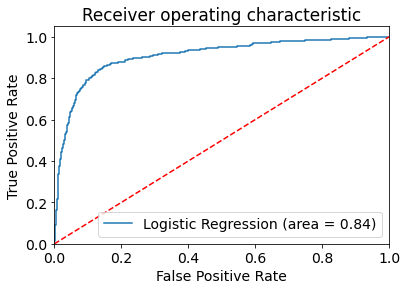

AUC = 0.9080710487473859


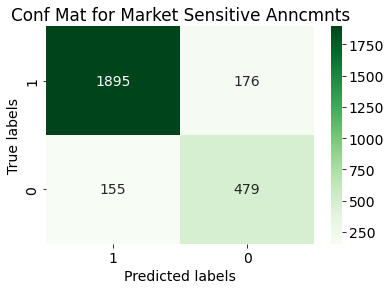

In [196]:
%time
legit_logit(dm=0,dm_mean=1,vec_size=800,wind=20,neg=5,mincnt=3,wrkrs=8,alph=0.065,minalph=0.065,epochrange=50,epchcnt=1)

2022-08-21 13:31:45,876 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dbow,d250,n5,s0.001,t8>', 'datetime': '2022-08-21T13:31:45.876542', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}


CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 9015/9015 [00:00<00:00, 4505678.09it/s]
2022-08-21 13:31:45,881 : INFO : collecting all words and their counts
2022-08-21 13:31:45,881 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-08-21 13:31:46,371 : INFO : collected 52037 word types and 2 unique tags from a corpus of 9015 examples and 4251309 words
2022-08-21 13:31:46,372 : INFO : Creating a fresh vocabulary
2022-08-21 13:31:46,509 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 52037 unique words (100.00% of original 52037, drops 0)', 'datetime': '2022-08-21T13:31:46.509572', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'prepare_vocab'}
2022-08-21 13:31:46,510 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 4251309 word corpus (100.00% of original 4251309, drops 0)', 'datetime': '2022-08-21T13:31:46.510542', 'gensim': '4.2.0

2022-08-21 13:32:01,747 : INFO : EPOCH 0 - PROGRESS: at 35.15% examples, 1336770 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:32:02,749 : INFO : EPOCH 0 - PROGRESS: at 71.09% examples, 1343525 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:32:03,526 : INFO : EPOCH 0: training on 4251309 raw words (3780086 effective words) took 2.8s, 1359587 effective words/s
2022-08-21 13:32:03,527 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780086 effective words) took 2.8s, 1357535 effective words/s', 'datetime': '2022-08-21T13:32:03.527567', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 3005695.59it/s]
2022-08-21 13:32:03,535 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '

100%|██████████| 9015/9015 [00:00<00:00, 4506215.06it/s]
2022-08-21 13:32:22,478 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022-08-21T13:32:22.478614', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 13:32:23,491 : INFO : EPOCH 0 - PROGRESS: at 27.96% examples, 1063511 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:32:24,506 : INFO : EPOCH 0 - PROGRESS: at 56.92% examples, 1073445 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:32:25,512 : INFO : EPOCH 0 - PROGRESS: at 86.79% examples, 1087687 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:32:25,919 : INFO : EPOCH 0: training on 4251309 raw words (3779826 effective words) took 3.4s, 1099543 effective words/s
2022-08-21 13:32:25,920 : INFO : Doc2Vec lifecycle event {'

2022-08-21 13:32:44,075 : INFO : EPOCH 0 - PROGRESS: at 28.51% examples, 1071044 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:32:45,076 : INFO : EPOCH 0 - PROGRESS: at 57.25% examples, 1079665 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:32:46,084 : INFO : EPOCH 0 - PROGRESS: at 86.01% examples, 1083512 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:32:46,534 : INFO : EPOCH 0: training on 4251309 raw words (3779938 effective words) took 3.5s, 1092190 effective words/s
2022-08-21 13:32:46,534 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3779938 effective words) took 3.5s, 1090951 effective words/s', 'datetime': '2022-08-21T13:32:46.534631', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4506215.06it/s]
2022-08-21 13:32:46,540 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037

2022-08-21 13:33:07,819 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3779901 effective words) took 3.6s, 1041242 effective words/s', 'datetime': '2022-08-21T13:33:07.819720', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4505678.09it/s]
2022-08-21 13:33:07,824 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022-08-21T13:33:07.824721', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 13:33:08,843 : INFO : EPOCH 0 - PROGRESS: at 26.69% examples, 990421 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:33:09,850 : INFO : EPOCH 0 - PROGRESS: at 54.70% exa

2022-08-21 13:33:52,476 : INFO : EPOCH 0 - PROGRESS: at 27.57% examples, 1022994 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:33:53,485 : INFO : EPOCH 0 - PROGRESS: at 56.17% examples, 1047505 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:33:54,491 : INFO : EPOCH 0 - PROGRESS: at 83.28% examples, 1042844 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:33:55,058 : INFO : EPOCH 0: training on 4251309 raw words (3780368 effective words) took 3.6s, 1054269 effective words/s
2022-08-21 13:33:55,059 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780368 effective words) took 3.6s, 1053060 effective words/s', 'datetime': '2022-08-21T13:33:55.059877', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4507289.37it/s]
2022-08-21 13:33:55,064 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037

2022-08-21 13:34:17,072 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780675 effective words) took 3.7s, 1017747 effective words/s', 'datetime': '2022-08-21T13:34:17.072878', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4509977.40it/s]
2022-08-21 13:34:17,077 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022-08-21T13:34:17.077876', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 13:34:18,087 : INFO : EPOCH 0 - PROGRESS: at 26.68% examples, 1003653 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:34:19,099 : INFO : EPOCH 0 - PROGRESS: at 54.14% ex

Testing accuracy 0.889463955637708
Testing F1 score: 0.8898508240292763
Testing accuracy 0.889463955637708
Testing F1 score: 0.8898508240292763


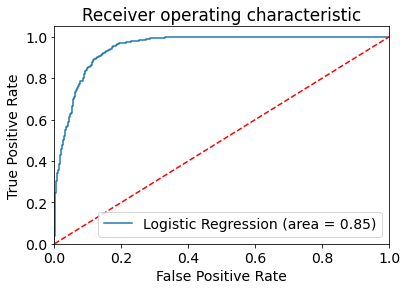

AUC = 0.9510180394116133


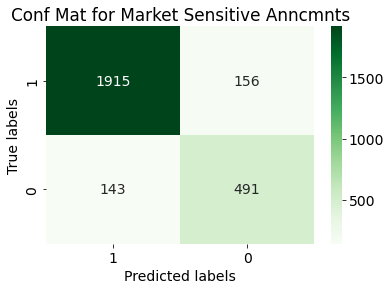

In [197]:
%time
legit_logit(dm=0,dm_mean=1,vec_size=250,wind=20,neg=5,mincnt=3,wrkrs=8,alph=0.065,minalph=0.065,epochrange=50,epchcnt=1)

2022-08-21 13:41:41,662 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dbow,d250,n5,s0.001,t8>', 'datetime': '2022-08-21T13:41:41.662085', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}


CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 9015/9015 [00:00<00:00, 4506215.06it/s]
2022-08-21 13:41:41,667 : INFO : collecting all words and their counts
2022-08-21 13:41:41,667 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-08-21 13:41:42,158 : INFO : collected 52037 word types and 2 unique tags from a corpus of 9015 examples and 4251309 words
2022-08-21 13:41:42,159 : INFO : Creating a fresh vocabulary
2022-08-21 13:41:42,297 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 52037 unique words (100.00% of original 52037, drops 0)', 'datetime': '2022-08-21T13:41:42.297108', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'prepare_vocab'}
2022-08-21 13:41:42,298 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 4251309 word corpus (100.00% of original 4251309, drops 0)', 'datetime': '2022-08-21T13:41:42.298111', 'gensim': '4.2.0

2022-08-21 13:41:58,683 : INFO : EPOCH 0 - PROGRESS: at 32.85% examples, 1210801 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:41:59,689 : INFO : EPOCH 0 - PROGRESS: at 66.40% examples, 1226802 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:42:00,690 : INFO : EPOCH 0 - PROGRESS: at 98.95% examples, 1235202 words/s, in_qsize 5, out_qsize 1
2022-08-21 13:42:00,700 : INFO : EPOCH 0: training on 4251309 raw words (3780931 effective words) took 3.0s, 1245116 effective words/s
2022-08-21 13:42:00,701 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780931 effective words) took 3.0s, 1243493 effective words/s', 'datetime': '2022-08-21T13:42:00.701081', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4507289.37it/s]
2022-08-21 13:42:00,706 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 

100%|██████████| 9015/9015 [00:00<00:00, 4506752.15it/s]
2022-08-21 13:42:18,839 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022-08-21T13:42:18.839082', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 13:42:19,849 : INFO : EPOCH 0 - PROGRESS: at 31.10% examples, 1201548 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:42:20,849 : INFO : EPOCH 0 - PROGRESS: at 65.00% examples, 1231001 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:42:21,865 : INFO : EPOCH 0 - PROGRESS: at 98.80% examples, 1234313 words/s, in_qsize 6, out_qsize 1
2022-08-21 13:42:21,876 : INFO : EPOCH 0: training on 4251309 raw words (3780775 effective words) took 3.0s, 1246476 effective words/s
2022-08-21 13:42:21,876 : INFO : Doc2Vec lifecycle event {'m

100%|██████████| 9015/9015 [00:00<00:00, 4507826.72it/s]
2022-08-21 13:42:39,863 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022-08-21T13:42:39.863129', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 13:42:40,868 : INFO : EPOCH 0 - PROGRESS: at 33.49% examples, 1252063 words/s, in_qsize 15, out_qsize 1
2022-08-21 13:42:41,897 : INFO : EPOCH 0 - PROGRESS: at 67.48% examples, 1257497 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:42:42,818 : INFO : EPOCH 0: training on 4251309 raw words (3780063 effective words) took 3.0s, 1280613 effective words/s
2022-08-21 13:42:42,819 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780063 effective words) took 3.0s, 1278914 effective words/s', 'datetime': '

2022-08-21 13:43:01,893 : INFO : EPOCH 0: training on 4251309 raw words (3780290 effective words) took 3.6s, 1058696 effective words/s
2022-08-21 13:43:01,894 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780290 effective words) took 3.6s, 1057445 effective words/s', 'datetime': '2022-08-21T13:43:01.894128', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4507289.37it/s]
2022-08-21 13:43:01,899 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022-08-21T13:43:01.899128', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 13:43:02,906 : INFO : EPOCH 0 - PR

100%|██████████| 9015/9015 [00:00<00:00, 4506752.15it/s]
2022-08-21 13:43:23,592 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022-08-21T13:43:23.592145', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 13:43:24,603 : INFO : EPOCH 0 - PROGRESS: at 26.73% examples, 1015645 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:43:25,613 : INFO : EPOCH 0 - PROGRESS: at 53.84% examples, 1023282 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:43:26,623 : INFO : EPOCH 0 - PROGRESS: at 81.92% examples, 1025437 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:43:27,218 : INFO : EPOCH 0: training on 4251309 raw words (3780496 effective words) took 3.6s, 1043503 effective words/s
2022-08-21 13:43:27,218 : INFO : Doc2Vec lifecycle event {'

2022-08-21 13:43:46,706 : INFO : EPOCH 0 - PROGRESS: at 25.06% examples, 945816 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:43:47,711 : INFO : EPOCH 0 - PROGRESS: at 51.97% examples, 968157 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:43:48,715 : INFO : EPOCH 0 - PROGRESS: at 78.10% examples, 976544 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:43:49,545 : INFO : EPOCH 0: training on 4251309 raw words (3779288 effective words) took 3.8s, 983492 effective words/s
2022-08-21 13:43:49,546 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3779288 effective words) took 3.8s, 982534 effective words/s', 'datetime': '2022-08-21T13:43:49.546733', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4509439.54it/s]
2022-08-21 13:43:49,551 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 voca

2022-08-21 13:44:12,469 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3779861 effective words) took 3.8s, 994386 effective words/s', 'datetime': '2022-08-21T13:44:12.469794', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4504604.55it/s]
2022-08-21 13:44:12,475 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022-08-21T13:44:12.475795', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 13:44:13,480 : INFO : EPOCH 0 - PROGRESS: at 24.28% examples, 926640 words/s, in_qsize 14, out_qsize 1
2022-08-21 13:44:14,489 : INFO : EPOCH 0 - PROGRESS: at 51.60% exam

Testing accuracy 0.8927911275415896
Testing F1 score: 0.8931379177426789
Testing accuracy 0.8927911275415896
Testing F1 score: 0.8931379177426789


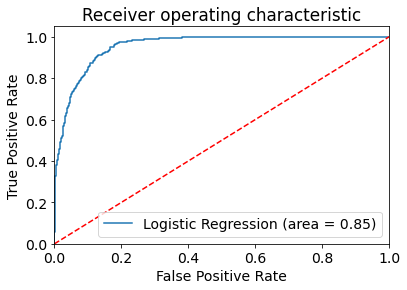

AUC = 0.9548100781865234


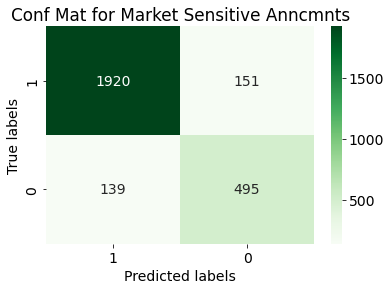

In [198]:
%time
legit_logit(dm=0,dm_mean=1,vec_size=250,wind=20,neg=5,mincnt=8,wrkrs=8,alph=0.065,minalph=0.065,epochrange=50,epchcnt=1)

2022-08-21 13:51:34,896 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dbow,d250,n5,s0.001,t8>', 'datetime': '2022-08-21T13:51:34.896702', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}


CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 9015/9015 [00:00<00:00, 3004501.44it/s]
2022-08-21 13:51:34,901 : INFO : collecting all words and their counts
2022-08-21 13:51:34,902 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-08-21 13:51:35,398 : INFO : collected 52037 word types and 2 unique tags from a corpus of 9015 examples and 4251309 words
2022-08-21 13:51:35,399 : INFO : Creating a fresh vocabulary
2022-08-21 13:51:35,541 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 52037 unique words (100.00% of original 52037, drops 0)', 'datetime': '2022-08-21T13:51:35.541701', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'prepare_vocab'}
2022-08-21 13:51:35,542 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 4251309 word corpus (100.00% of original 4251309, drops 0)', 'datetime': '2022-08-21T13:51:35.542740', 'gensim': '4.2.0

2022-08-21 13:51:51,327 : INFO : EPOCH 0 - PROGRESS: at 28.19% examples, 1062581 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:51:52,331 : INFO : EPOCH 0 - PROGRESS: at 57.13% examples, 1078853 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:51:53,348 : INFO : EPOCH 0 - PROGRESS: at 86.90% examples, 1084747 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:51:53,759 : INFO : EPOCH 0: training on 4251309 raw words (3780373 effective words) took 3.4s, 1098299 effective words/s
2022-08-21 13:51:53,760 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780373 effective words) took 3.4s, 1097127 effective words/s', 'datetime': '2022-08-21T13:51:53.760440', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4506215.06it/s]
2022-08-21 13:51:53,765 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037

2022-08-21 13:52:14,316 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780295 effective words) took 3.4s, 1099422 effective words/s', 'datetime': '2022-08-21T13:52:14.316534', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4508364.20it/s]
2022-08-21 13:52:14,321 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=5 window=20 shrink_windows=True', 'datetime': '2022-08-21T13:52:14.321535', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 13:52:15,336 : INFO : EPOCH 0 - PROGRESS: at 28.56% examples, 1076753 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:52:16,344 : INFO : EPOCH 0 - PROGRESS: at 58.08% ex

2022-08-21 13:52:56,246 : INFO : EPOCH 0 - PROGRESS: at 28.89% examples, 1074084 words/s, in_qsize 16, out_qsize 0
2022-08-21 13:52:57,256 : INFO : EPOCH 0 - PROGRESS: at 58.66% examples, 1094489 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:52:58,263 : INFO : EPOCH 0 - PROGRESS: at 87.63% examples, 1089352 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:52:58,670 : INFO : EPOCH 0: training on 4251309 raw words (3780105 effective words) took 3.4s, 1101738 effective words/s
2022-08-21 13:52:58,670 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780105 effective words) took 3.4s, 1100536 effective words/s', 'datetime': '2022-08-21T13:52:58.670686', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4511591.76it/s]
2022-08-21 13:52:58,676 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037

Testing accuracy 0.8872458410351202
Testing F1 score: 0.8873380476331528
Testing accuracy 0.8872458410351202
Testing F1 score: 0.8873380476331528


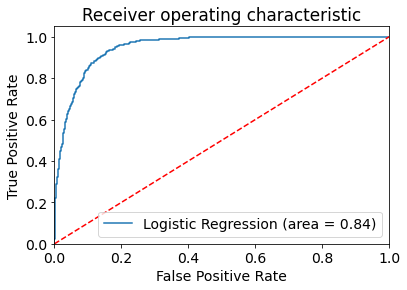

AUC = 0.9502518632703078


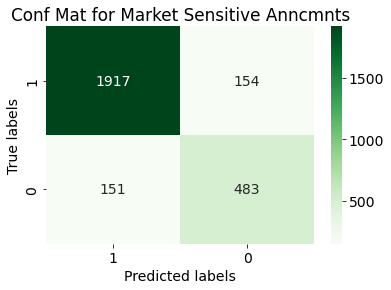

In [199]:
%time
legit_logit(dm=0,dm_mean=1,vec_size=250,wind=20,neg=5,mincnt=1,wrkrs=8,alph=0.065,minalph=0.065,epochrange=30,epchcnt=1)

2022-08-21 14:00:16,903 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dbow,d250,n20,s0.001,t8>', 'datetime': '2022-08-21T14:00:16.903162', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}


CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 9015/9015 [00:00<00:00, 4502995.18it/s]
2022-08-21 14:00:16,908 : INFO : collecting all words and their counts
2022-08-21 14:00:16,908 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-08-21 14:00:17,404 : INFO : collected 52037 word types and 2 unique tags from a corpus of 9015 examples and 4251309 words
2022-08-21 14:00:17,405 : INFO : Creating a fresh vocabulary
2022-08-21 14:00:17,541 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 52037 unique words (100.00% of original 52037, drops 0)', 'datetime': '2022-08-21T14:00:17.541161', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'prepare_vocab'}
2022-08-21 14:00:17,541 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 4251309 word corpus (100.00% of original 4251309, drops 0)', 'datetime': '2022-08-21T14:00:17.541161', 'gensim': '4.2.0

100%|██████████| 9015/9015 [00:00<00:00, 4507289.37it/s]
2022-08-21 14:00:43,180 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=20 window=20 shrink_windows=True', 'datetime': '2022-08-21T14:00:43.180672', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 14:00:44,202 : INFO : EPOCH 0 - PROGRESS: at 14.61% examples, 535317 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:00:45,204 : INFO : EPOCH 0 - PROGRESS: at 28.51% examples, 535467 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:00:46,232 : INFO : EPOCH 0 - PROGRESS: at 43.84% examples, 546409 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:00:47,233 : INFO : EPOCH 0 - PROGRESS: at 59.32% examples, 549991 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:00:48,249 : INFO : EPOCH 0 - PROGRESS: at 74.29% examples, 551138 wo

100%|██████████| 9015/9015 [00:00<00:00, 4509439.54it/s]
2022-08-21 14:01:49,455 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=20 window=20 shrink_windows=True', 'datetime': '2022-08-21T14:01:49.455268', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 14:01:50,464 : INFO : EPOCH 0 - PROGRESS: at 15.26% examples, 560292 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:01:51,468 : INFO : EPOCH 0 - PROGRESS: at 30.56% examples, 573598 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:01:52,468 : INFO : EPOCH 0 - PROGRESS: at 46.89% examples, 583771 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:01:53,498 : INFO : EPOCH 0 - PROGRESS: at 62.73% examples, 586104 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:01:54,498 : INFO : EPOCH 0 - PROGRESS: at 79.10% examples, 590539 wo

100%|██████████| 9015/9015 [00:00<00:00, 4510515.40it/s]
2022-08-21 14:02:55,716 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=20 window=20 shrink_windows=True', 'datetime': '2022-08-21T14:02:55.716950', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 14:02:56,732 : INFO : EPOCH 0 - PROGRESS: at 14.36% examples, 530915 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:02:57,739 : INFO : EPOCH 0 - PROGRESS: at 29.57% examples, 552724 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:02:58,740 : INFO : EPOCH 0 - PROGRESS: at 44.18% examples, 554470 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:02:59,759 : INFO : EPOCH 0 - PROGRESS: at 58.49% examples, 552601 words/s, in_qsize 14, out_qsize 1
2022-08-21 14:03:00,776 : INFO : EPOCH 0 - PROGRESS: at 74.24% examples, 556261 wo

2022-08-21 14:03:28,924 : INFO : EPOCH 0 - PROGRESS: at 13.94% examples, 530517 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:03:29,934 : INFO : EPOCH 0 - PROGRESS: at 29.00% examples, 535649 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:03:30,941 : INFO : EPOCH 0 - PROGRESS: at 43.85% examples, 548248 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:03:31,951 : INFO : EPOCH 0 - PROGRESS: at 58.45% examples, 551088 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:03:32,959 : INFO : EPOCH 0 - PROGRESS: at 73.29% examples, 552267 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:03:33,974 : INFO : EPOCH 0 - PROGRESS: at 88.18% examples, 550822 words/s, in_qsize 14, out_qsize 1
2022-08-21 14:03:34,754 : INFO : EPOCH 0: training on 4251309 raw words (3780956 effective words) took 6.8s, 553126 effective words/s
2022-08-21 14:03:34,754 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780956 effective words) took 6.8s, 552763 effective words/s', 'datetime': '2022-08-2

Testing accuracy 0.8927911275415896
Testing F1 score: 0.8933074559300415
Testing accuracy 0.8927911275415896
Testing F1 score: 0.8933074559300415


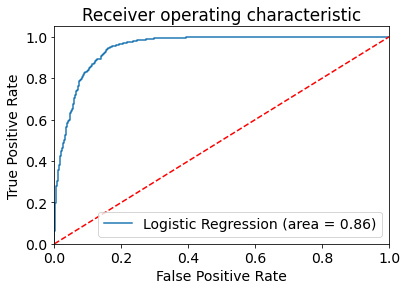

AUC = 0.9494826407029933


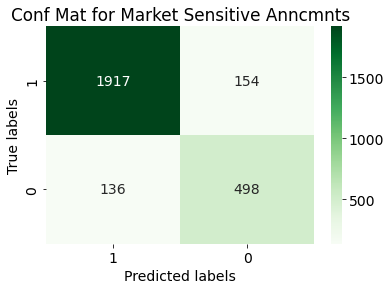

In [200]:
%time
legit_logit(dm=0,dm_mean=1,vec_size=250,wind=20,neg=20,mincnt=1,wrkrs=8,alph=0.065,minalph=0.065,epochrange=30,epchcnt=1)

2022-08-21 13:09:26,922 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dbow,d250,n1,s0.001,t8>', 'datetime': '2022-08-21T13:09:26.922988', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}


CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 9015/9015 [00:00<00:00, 3036836.44it/s]
2022-08-21 13:09:26,927 : INFO : collecting all words and their counts
2022-08-21 13:09:26,928 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-08-21 13:09:27,422 : INFO : collected 52037 word types and 2 unique tags from a corpus of 9015 examples and 4251309 words
2022-08-21 13:09:27,423 : INFO : Creating a fresh vocabulary
2022-08-21 13:09:27,560 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 52037 unique words (100.00% of original 52037, drops 0)', 'datetime': '2022-08-21T13:09:27.560988', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'prepare_vocab'}
2022-08-21 13:09:27,562 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 4251309 word corpus (100.00% of original 4251309, drops 0)', 'datetime': '2022-08-21T13:09:27.562000', 'gensim': '4.2.0

100%|██████████| 9015/9015 [00:00<00:00, 4511053.51it/s]
2022-08-21 13:09:36,646 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=1 window=20 shrink_windows=True', 'datetime': '2022-08-21T13:09:36.646959', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 13:09:37,653 : INFO : EPOCH 0 - PROGRESS: at 67.54% examples, 2566891 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:09:38,109 : INFO : EPOCH 0: training on 4251309 raw words (3780546 effective words) took 1.5s, 2591232 effective words/s
2022-08-21 13:09:38,110 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780546 effective words) took 1.5s, 2584293 effective words/s', 'datetime': '2022-08-21T13:09:38.110958', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit 

2022-08-21 13:09:48,348 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780324 effective words) took 1.5s, 2584937 effective words/s', 'datetime': '2022-08-21T13:09:48.348958', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4507289.37it/s]
2022-08-21 13:09:48,353 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=1 window=20 shrink_windows=True', 'datetime': '2022-08-21T13:09:48.353958', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 13:09:49,359 : INFO : EPOCH 0 - PROGRESS: at 67.78% examples, 2580927 words/s, in_qsize 15, out_qsize 0
2022-08-21 13:09:49,811 : INFO : EPOCH 0: training on 4251309 raw

2022-08-21 13:09:59,603 : INFO : EPOCH 0 - PROGRESS: at 67.24% examples, 2557758 words/s, in_qsize 14, out_qsize 1
2022-08-21 13:10:00,053 : INFO : EPOCH 0: training on 4251309 raw words (3780368 effective words) took 1.5s, 2599647 effective words/s
2022-08-21 13:10:00,054 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780368 effective words) took 1.5s, 2592632 effective words/s', 'datetime': '2022-08-21T13:10:00.054958', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4508364.20it/s]
2022-08-21 13:10:00,059 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=1 window=20 shrink_windows=True', 'datetime': '2022-08-21T13:10:00.059959', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit 

2022-08-21 13:10:11,288 : INFO : EPOCH 0 - PROGRESS: at 68.75% examples, 2579913 words/s, in_qsize 14, out_qsize 1
2022-08-21 13:10:11,740 : INFO : EPOCH 0: training on 4251309 raw words (3780374 effective words) took 1.5s, 2600249 effective words/s
2022-08-21 13:10:11,740 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780374 effective words) took 1.5s, 2592634 effective words/s', 'datetime': '2022-08-21T13:10:11.740958', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}


Testing accuracy 0.8972273567467652
Testing F1 score: 0.8971709780719337
Testing accuracy 0.8972273567467652
Testing F1 score: 0.8971709780719337


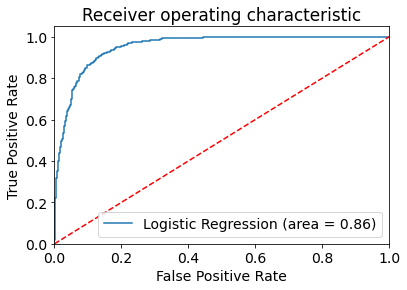

AUC = 0.9517103397221963


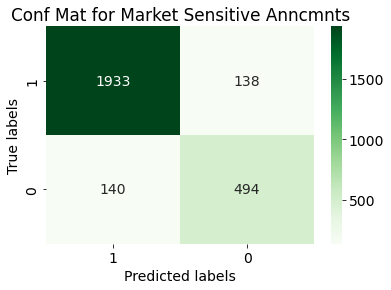

In [195]:
#WINNER WINNER
%time
legit_logit(dm=0,dm_mean=1,vec_size=250,wind=20,neg=1,mincnt=1,wrkrs=8,alph=0.065,minalph=0.065,epochrange=30,epchcnt=1)

2022-08-21 16:30:43,930 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dbow,d250,n1,s0.001,t8>', 'datetime': '2022-08-21T16:30:43.930082', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}
100%|██████████| 9015/9015 [00:00<00:00, 1287818.89it/s]
2022-08-21 16:30:44,058 : INFO : collecting all words and their counts
2022-08-21 16:30:44,059 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-08-21 16:30:44,798 : INFO : collected 52037 word types and 2 unique tags from a corpus of 9015 examples and 4251309 words
2022-08-21 16:30:44,799 : INFO : Creating a fresh vocabulary
2022-08-21 16:30:44,942 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 52037 unique words (100.00% of original 52037, drops 0)', 'datetime': '2022-08-21T16:30:44.942038', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1

2022-08-21 16:30:53,740 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780483 effective words) took 1.4s, 2682828 effective words/s', 'datetime': '2022-08-21T16:30:53.740038', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 3005695.59it/s]
2022-08-21 16:30:53,746 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=1 window=20 shrink_windows=True', 'datetime': '2022-08-21T16:30:53.746038', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 16:30:54,750 : INFO : EPOCH 0 - PROGRESS: at 69.58% examples, 2645296 words/s, in_qsize 15, out_qsize 0
2022-08-21 16:30:55,156 : INFO : EPOCH 0: training on 4251309 raw

2022-08-21 16:31:04,760 : INFO : EPOCH 0 - PROGRESS: at 68.89% examples, 2600254 words/s, in_qsize 15, out_qsize 0
2022-08-21 16:31:05,193 : INFO : EPOCH 0: training on 4251309 raw words (3781775 effective words) took 1.4s, 2634473 effective words/s
2022-08-21 16:31:05,193 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3781775 effective words) took 1.4s, 2627602 effective words/s', 'datetime': '2022-08-21T16:31:05.193038', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4507826.72it/s]
2022-08-21 16:31:05,199 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=1 window=20 shrink_windows=True', 'datetime': '2022-08-21T16:31:05.199038', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit 

2022-08-21 16:31:16,281 : INFO : EPOCH 0 - PROGRESS: at 68.90% examples, 2599051 words/s, in_qsize 14, out_qsize 1
2022-08-21 16:31:16,716 : INFO : EPOCH 0: training on 4251309 raw words (3779832 effective words) took 1.4s, 2631530 effective words/s
2022-08-21 16:31:16,716 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3779832 effective words) took 1.4s, 2624218 effective words/s', 'datetime': '2022-08-21T16:31:16.716037', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4506215.06it/s]
2022-08-21 16:31:16,721 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=1 window=20 shrink_windows=True', 'datetime': '2022-08-21T16:31:16.721038', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit 

2022-08-21 16:31:27,816 : INFO : EPOCH 0 - PROGRESS: at 70.73% examples, 2638159 words/s, in_qsize 15, out_qsize 0
2022-08-21 16:31:28,225 : INFO : EPOCH 0: training on 4251309 raw words (3780592 effective words) took 1.4s, 2677134 effective words/s
2022-08-21 16:31:28,226 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780592 effective words) took 1.4s, 2669618 effective words/s', 'datetime': '2022-08-21T16:31:28.226038', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}


Testing accuracy 0.8939001848428836
Testing F1 score: 0.8943275945264478
Testing accuracy 0.8939001848428836
Testing F1 score: 0.8943275945264478


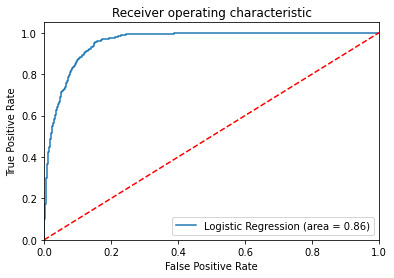

[0.00000000e+00 0.00000000e+00 0.00000000e+00 4.82858522e-04
 4.82858522e-04 9.65717045e-04 9.65717045e-04 1.44857557e-03
 1.44857557e-03 1.93143409e-03 1.93143409e-03 2.41429261e-03
 2.41429261e-03 2.89715113e-03 2.89715113e-03 3.38000966e-03
 3.38000966e-03 4.34572670e-03 4.34572670e-03 4.82858522e-03
 4.82858522e-03 5.31144375e-03 5.31144375e-03 5.79430227e-03
 5.79430227e-03 6.27716079e-03 6.27716079e-03 6.76001931e-03
 6.76001931e-03 7.24287784e-03 7.24287784e-03 7.72573636e-03
 7.72573636e-03 8.20859488e-03 8.20859488e-03 8.69145340e-03
 8.69145340e-03 9.17431193e-03 9.17431193e-03 9.65717045e-03
 9.65717045e-03 1.01400290e-02 1.01400290e-02 1.06228875e-02
 1.06228875e-02 1.11057460e-02 1.11057460e-02 1.15886045e-02
 1.15886045e-02 1.20714631e-02 1.20714631e-02 1.25543216e-02
 1.25543216e-02 1.35200386e-02 1.35200386e-02 1.40028972e-02
 1.40028972e-02 1.44857557e-02 1.44857557e-02 1.49686142e-02
 1.49686142e-02 1.59343312e-02 1.59343312e-02 1.64171898e-02
 1.64171898e-02 1.690004

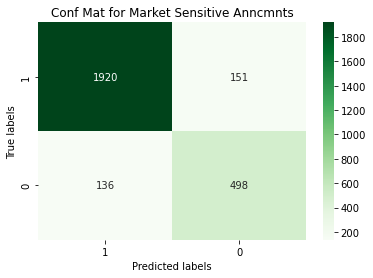

In [216]:
#now take the above out of the function and explicitly state function parameters so we can use lime afterwards
model_dmm = Doc2Vec(dm=0, dm_mean=1, vector_size=250, window=20, negative=1, min_count=1
                    ,workers=8, alpha=0.065, min_alpha=0.065)#,dbow_words=1) #comment out this last parameter - only being used for the last iteration
model_dmm.build_vocab([x for x in tqdm(all_tagged.values)])

for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(all_tagged.values)]), total_examples=len(all_tagged.values), epochs=1)
    #model_dmm.alpha -= 0.002
    #model_dmm.min_alpha = model_dmm.alpha

y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))  

#visualisations-------------
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

print(fpr)
print(tpr)
auc = metrics.auc(fpr, tpr)
print("AUC =", auc)

pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


#heatmap---------------------
ax= plt.subplot()
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Greens');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Conf Mat for Market Sensitive Anncmnts'); 
ax.xaxis.set_ticklabels([1, 0]); ax.yaxis.set_ticklabels([1, 0]);

In [215]:
from lime import lime_text
target_classes = [1, 0]
explainer = lime_text.LimeTextExplainer(class_names=target_classes, verbose=True)

explainer

In [217]:
def make_predictions(X_batch):
    preds = model.predict(X_batch)
    return preds

In [ ]:
explanation = explainer.explain_instance(X_test_text[idx], classifier_fn=make_predictions, labels=Y_test[idx:idx+1], num_features=15)
explanation.show_in_notebook()

2022-08-21 14:47:59,952 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dbow+w,d250,n1,w20,s0.001,t8>', 'datetime': '2022-08-21T14:47:59.952964', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}


CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 9015/9015 [00:00<00:00, 3054993.18it/s]
2022-08-21 14:47:59,958 : INFO : collecting all words and their counts
2022-08-21 14:47:59,959 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-08-21 14:48:00,479 : INFO : collected 52037 word types and 2 unique tags from a corpus of 9015 examples and 4251309 words
2022-08-21 14:48:00,479 : INFO : Creating a fresh vocabulary
2022-08-21 14:48:00,614 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 52037 unique words (100.00% of original 52037, drops 0)', 'datetime': '2022-08-21T14:48:00.614993', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'prepare_vocab'}
2022-08-21 14:48:00,615 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 4251309 word corpus (100.00% of original 4251309, drops 0)', 'datetime': '2022-08-21T14:48:00.615997', 'gensim': '4.2.0

100%|██████████| 9015/9015 [00:00<00:00, 4508364.20it/s]
2022-08-21 14:48:27,228 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=1 window=20 shrink_windows=True', 'datetime': '2022-08-21T14:48:27.228981', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 14:48:28,304 : INFO : EPOCH 0 - PROGRESS: at 16.36% examples, 581997 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:48:29,316 : INFO : EPOCH 0 - PROGRESS: at 33.29% examples, 603935 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:48:30,339 : INFO : EPOCH 0 - PROGRESS: at 49.55% examples, 604480 words/s, in_qsize 14, out_qsize 1
2022-08-21 14:48:31,343 : INFO : EPOCH 0 - PROGRESS: at 65.82% examples, 604025 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:48:32,347 : INFO : EPOCH 0 - PROGRESS: at 81.00% examples, 597391 wor

100%|██████████| 9015/9015 [00:00<00:00, 4511591.76it/s]
2022-08-21 14:49:36,479 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=1 window=20 shrink_windows=True', 'datetime': '2022-08-21T14:49:36.479587', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 14:49:37,487 : INFO : EPOCH 0 - PROGRESS: at 12.31% examples, 462174 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:49:38,494 : INFO : EPOCH 0 - PROGRESS: at 24.98% examples, 473228 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:49:39,511 : INFO : EPOCH 0 - PROGRESS: at 37.98% examples, 473769 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:49:40,548 : INFO : EPOCH 0 - PROGRESS: at 51.49% examples, 477808 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:49:41,566 : INFO : EPOCH 0 - PROGRESS: at 64.71% examples, 479947 wor

2022-08-21 14:50:15,325 : INFO : EPOCH 0: training on 4251309 raw words (3780827 effective words) took 7.8s, 484271 effective words/s
2022-08-21 14:50:15,326 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3780827 effective words) took 7.8s, 484007 effective words/s', 'datetime': '2022-08-21T14:50:15.326674', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4505141.26it/s]
2022-08-21 14:50:15,331 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=1 window=20 shrink_windows=True', 'datetime': '2022-08-21T14:50:15.331676', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 14:50:16,343 : INFO : EPOCH 0 - PROG

2022-08-21 14:50:50,029 : INFO : EPOCH 0 - PROGRESS: at 68.33% examples, 506613 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:50:51,043 : INFO : EPOCH 0 - PROGRESS: at 81.82% examples, 507306 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:50:52,048 : INFO : EPOCH 0 - PROGRESS: at 96.00% examples, 510838 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:50:52,329 : INFO : EPOCH 0: training on 4251309 raw words (3779997 effective words) took 7.4s, 513494 effective words/s
2022-08-21 14:50:52,330 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4251309 raw words (3779997 effective words) took 7.4s, 512998 effective words/s', 'datetime': '2022-08-21T14:50:52.330234', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
100%|██████████| 9015/9015 [00:00<00:00, 4508901.81it/s]
2022-08-21 14:50:52,335 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 voca

2022-08-21 14:51:22,388 : INFO : EPOCH 0 - PROGRESS: at 14.31% examples, 482526 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:51:23,390 : INFO : EPOCH 0 - PROGRESS: at 28.82% examples, 514851 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:51:24,404 : INFO : EPOCH 0 - PROGRESS: at 43.53% examples, 523302 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:51:25,409 : INFO : EPOCH 0 - PROGRESS: at 57.30% examples, 529192 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:51:26,425 : INFO : EPOCH 0 - PROGRESS: at 71.10% examples, 524932 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:51:27,436 : INFO : EPOCH 0 - PROGRESS: at 85.29% examples, 526615 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:51:28,451 : INFO : EPOCH 0 - PROGRESS: at 98.49% examples, 522870 words/s, in_qsize 7, out_qsize 1
2022-08-21 14:51:28,531 : INFO : EPOCH 0: training on 4251309 raw words (3780348 effective words) took 7.2s, 525392 effective words/s
2022-08-21 14:51:28,531 : INFO : Doc2Vec lifecycle event {'msg': 'tra

100%|██████████| 9015/9015 [00:00<00:00, 4507826.72it/s]
2022-08-21 14:51:58,938 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 8 workers on 52037 vocabulary and 250 features, using sg=1 hs=0 sample=0.001 negative=1 window=20 shrink_windows=True', 'datetime': '2022-08-21T14:51:58.938831', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
2022-08-21 14:51:59,984 : INFO : EPOCH 0 - PROGRESS: at 12.35% examples, 455687 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:52:00,993 : INFO : EPOCH 0 - PROGRESS: at 26.61% examples, 478549 words/s, in_qsize 16, out_qsize 0
2022-08-21 14:52:01,996 : INFO : EPOCH 0 - PROGRESS: at 40.06% examples, 483757 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:52:02,997 : INFO : EPOCH 0 - PROGRESS: at 52.55% examples, 487922 words/s, in_qsize 15, out_qsize 0
2022-08-21 14:52:04,016 : INFO : EPOCH 0 - PROGRESS: at 65.67% examples, 488690 wor

Testing accuracy 0.8817005545286506
Testing F1 score: 0.8815048944662351
Testing accuracy 0.8817005545286506
Testing F1 score: 0.8815048944662351


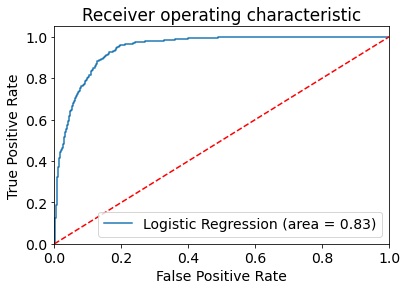

AttributeError: module 'sklearn.metrics' has no attribute 'Recall'

In [202]:

%time
legit_logit(dm=0,dm_mean=1,vec_size=250,wind=20,neg=1,mincnt=1,wrkrs=8,alph=0.065,minalph=0.065,epochrange=35,epchcnt=1)